# Optimization of the CRM-like Box Beam under Combined Bending and Torsional Load

In our [last notebook](22_Optimization_of_the_CRM-like_Box_Beam_with_Curved_Skins.ipynb) we performed a structural optimization of a variant of the CRM-like Box Beam employing curved skin and we compared the results with those of the original model employing flat skin.

In this notebook we are going to take the final intermediate step towards the aeroelastic optimization of the CRM-like Box Beam and we are going to do it by employing an applied load that is more similar to an aerodynamic load. For this reason, we are going to use a load that induces both bending and torsion at the same time, analogously to what happens in a real wing. In addition, since the magnitude of the applied loads considered so far has always been much smaller than that typically resulting from the sizing load cases in aeroelastic optimizations, we are also going to increase the load level and observe the effect on the response of the optimized structure.

* [Definition of the CRM-like Box Beam model](#model-definition)
* [Definition of the Applied Load](#applied-load)
* [Mesh Convergence Study](#mesh-convergence)
* [Mesh Convergence Verification](#mesh-verification)
* [Linear Buckling Optimization](#linear)
* [Nonlinear Structural Stability Optimization](#nonlinear)
* [Influence of Load Level](#load-level)
   * [Linear Buckling Optimization](#load-level-linear)
   * [Nonlinear Structural Stability Optimization](#load-level-nonlinear)
* [Conclusions](#conclusions)

In [1]:
import matplotlib.pyplot as plt  # package for making plots
import tol_colors as tc  # package for colorblind-friendly colors
import os  # package for file and directory manipulation
from matplotlib.lines import Line2D  # class defining the characters for the marker styles

# Set up matplotlib for interactive plotting and set default plot settings
%matplotlib widget
plt.rc('axes', prop_cycle=plt.cycler('color', list(tc.tol_cset('bright'))))  # set default color cycle to TOL bright
plt.rcParams["figure.dpi"] = 120  # set default dpi of figures

# Set the path to the directory containing the analysis files
ANALYSIS_DIRECTORY_PATH = os.path.join(
    os.getcwd(), "analyses", "23_Optimization_of_the_CRM-like_Box_Beam_under_Combined_Bending_and_Torsional_Load")

# Set the environment variable for the directory containing the report files
REPORT_DIRECTORY_PATH = os.path.relpath(ANALYSIS_DIRECTORY_PATH, os.getcwd())
os.environ['OPENMDAO_REPORTS_DIR'] = REPORT_DIRECTORY_PATH

# Define constant variables related to the optimization
OPTIMIZER_TOLERANCE = 1e-3  # convergence tolerance for the optimizer
EIGENVALUE_SCALE_FACTOR = 1e3  # scaling factor to convert eigenvalues from N/mm to N/m

# Define constant variables related to Nastran analysis
FIRST_SUBCASE_ID = 1   # id of the first subcase
SECOND_SUBCASE_ID = 2  # id of the second subcase
Z_COMPONENT_INDEX = 2  # index of z-component in load and displacement array
FORCE_SET_ID = 11      # id for force cards
LOAD_SET_ID = 12       # id of load set
METHOD_SET_ID = 13     # id of method for eigenvalue calculation
NO_EIGENVALUES = 20    # number of eigenvalues to extract from the Nastran analysis
UPPER_EIGENVALUE = 100.  # upper bound for eigenvalues [N/mm] - set to 10^5 N/m to avoid convergence issues of Lanczos solver

# Define constant variables related to the plots
MARKERS = list(Line2D.markers.keys())[2:]  # list of marker characters
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']  # list with default color cycle
UNSTABLE_COLOR = COLORS[1]  # color for unstable segments
LINEAR_BUCKLING_COLOR = COLORS[2]  # green is used for glass ceiling
del COLORS[1:3]  # delete red from list of colors
LENGTH_SCALE_FACTOR = 1e-3  # scaling factor to convert lengths from mm to m

## Definition of the CRM-like Box Beam model <a name="model-definition"></a>

***

We recall geometry and structural arrangement of the CRM-like Box Beam derived in [notebook 18](18_Development_and_Nonlinear_Structural_Stability_Analysis_of_a_CRM-like_Box_Beam_Model.ipynb).

In [2]:
import numpy as np  # import numpy library

L = 29.38e3  # [mm] box beam length
W = 3.41e3  # [mm] box beam width
H = 0.77e3  # [mm] box beam height
H_A = H/15  # [mm] height of skin arch
t_0 = H/100  # [mm] initial box beam thickness
H_S = H/10  # [mm] stiffeners height
no_stiffeners = 2  # number of stiffeners
STIFFENERS_X_LOCATIONS = np.linspace(0, W, no_stiffeners + 2)[1:-1]  # [mm] stiffeners x-coordinates
stiffeners_spacing = W/(no_stiffeners + 1)  # [mm] stiffeners spacing
ribs_spacing = stiffeners_spacing*1.4 # [mm] ribs spacing
no_ribs = round(L/ribs_spacing) + 1  # number of ribs
RIBS_Y_LOCATIONS = np.linspace(0, L, no_ribs)  # [mm] ribs y-coordinates
print(f"""
Number of stiffeners: {no_stiffeners:d}
Number of ribs: {no_ribs:d}""")  # print number of stiffeners and ribs


Number of stiffeners: 2
Number of ribs: 19


Then we recall the material properties, taken from [Brooks et al. (2018)](https://arc.aiaa.org/doi/10.2514/1.J056603).

In [3]:
RHO = 2780e-12  # density [tons/mm^3]
E = 73.1e3  # Young's modulus [MPa]
NU = 0.3  # Poisson's ratio
SIGMA_Y = 420.  # yield strength [MPa]

## Definition of the Applied Load <a name="applied-load"></a>

***

In this notebook we want to modify the applied load employed in our [last notebook](22_Optimization_of_the_CRM-like_Box_Beam_with_Curved_Skins.ipynb) in such a way to induce both bending and torsion at the same time. To achieve this goal, we maintain an elliptical distribution of the load along the span of the CRM-like Box Beam and we introduce a linear distribution along the width. For every spanwise station, we define the load applied at the front spar to be equal to three times the load applied at the rear spar. Consequently, the load over each skin is defined as follows:

$$P(x,y) = \frac{1}{F}\sqrt{1 - \left(\frac{y}{l}\right)^2} \left(1 - \frac{2}{3}\frac{x}{w}\right),$$

where $l$ and $w$ are the length and width of the CRM-like Box Beam, and $y$ and $x$ are the coordinates along the respective directions. The factor $1/F$ is introduced to ensure that the magnitude of the applied load over each skin is equal to $1/2$ N, so that the overall magnitude is equal to 1 N. In this way, we can easily scale the total applied load to any desired value.

To apply this load to our Nastran model, we define the function `apply_bending_torsion_load`. This function takes as input the `BDF` object representing the Nastran input file and the `PolyData` object representing the mesh of the CRM-like Box Beam. The function then applies the described load to the model by creating a FORCE card for each skin node of the mesh.

In [4]:
from scipy.optimize import fsolve  # import fsolve from scipy library
from resources import pynastran_utils  # import pynastran_utils module from resources folder

# Define constant variable setting tolerance to find nodes at specific locations
NODE_TOLERANCE = 1e-3  # [mm]

def apply_bending_torsion_load(bdf, mesh):
    # Create array of nodes' coordinates and ids
    nodes_xyz_array = mesh.points
    nodes_ids = np.arange(1, len(nodes_xyz_array) + 1)
    
    # Create array with unique y-coordinates within tolerance
    x_coordinates = np.unique(nodes_xyz_array[:, 0].round(decimals=int(np.abs(np.log10(NODE_TOLERANCE)))))
    y_coordinates = np.unique(nodes_xyz_array[:, 1].round(decimals=int(np.abs(np.log10(NODE_TOLERANCE)))))
    
    # Find the scaling factor that makes the total applied load equal to 1
    x_array_2d, y_array_2d = np.meshgrid(x_coordinates, y_coordinates)
    f = lambda s: np.sum(s * np.sqrt(1 - (y_array_2d / L)**2)*(1 - 2/3*x_array_2d/W)) - 1  # function to be solved to find the correct scaling factor
    scaling_factor_guess = 4 / (np.pi * L)  # initial guess for the solver
    scaling_factor = fsolve(f, scaling_factor_guess)[0]  # find the root of the function to find the scaling factor
    
    # Compute local forces at each x- and y-coordinate
    local_forces = scaling_factor/2 * np.sqrt(1 - (y_array_2d / L)**2) * (1 - 2/3*x_array_2d/W)  # scaling factor is divided by 2 because the force is applied over both top and bottom skin
    
    # Find top skin nodes ids and coordinates
    top_skin_nodes_indices = np.flatnonzero(np.char.find(mesh.point_data['tags'], "top skin")!=-1)  # find indices of top skin nodes
    top_skin_nodes_ids = nodes_ids[top_skin_nodes_indices]  # find ids of top skin nodes
    top_skin_nodes_xyz_array = nodes_xyz_array[top_skin_nodes_indices]  # find coordinates of top skin nodes
    
    # Find bottom skin nodes ids and coordinates
    bottom_skin_nodes_indices = np.flatnonzero(np.char.find(mesh.point_data['tags'], "bottom skin")!=-1)  # find indices of bottom skin nodes
    bottom_skin_nodes_ids = nodes_ids[bottom_skin_nodes_indices]  # find ids of bottom skin nodes
    bottom_skin_nodes_xyz_array = nodes_xyz_array[bottom_skin_nodes_indices]  # find coordinates of bottom skin nodes
    
    # Loop over y-coordinates
    for i, y in enumerate(y_coordinates):
        
        # Find top skin nodes ids and coordinates at current y-coordinate
        top_skin_current_y_nodes_indices = np.abs(top_skin_nodes_xyz_array[:, 1] - y) < NODE_TOLERANCE  # find indices of top skin nodes at current y-coordinate
        top_skin_current_y_nodes_ids = top_skin_nodes_ids[top_skin_current_y_nodes_indices]  # find ids of top skin nodes at current y-coordinate
        top_skin_current_y_nodes_xyz_array = top_skin_nodes_xyz_array[top_skin_current_y_nodes_indices]  # find coordinates of top skin nodes at current y-coordinate
        
        # Find bottom skin nodes ids and coordinates at current y-coordinate
        bottom_skin_current_y_nodes_indices = np.abs(bottom_skin_nodes_xyz_array[:, 1] - y) < NODE_TOLERANCE
        bottom_skin_current_y_nodes_ids = bottom_skin_nodes_ids[bottom_skin_current_y_nodes_indices]
        bottom_skin_current_y_nodes_xyz_array = bottom_skin_nodes_xyz_array[bottom_skin_current_y_nodes_indices]
        
        # Loop over x-coordinates
        for j, x in enumerate(x_coordinates):
            
            # Find force magnitude at current x- and y-coordinate
            force_magnitude = local_forces[i, j]
            
            # Find top skin node at current x-coordinate
            top_skin_force_node_id = top_skin_current_y_nodes_ids[np.abs(top_skin_current_y_nodes_xyz_array[:, 0] - x) < NODE_TOLERANCE]  # find id of top skin node at current x-coordinate
            
            # Find bottom skin node at current x-coordinate
            bottom_skin_force_node_id = bottom_skin_current_y_nodes_ids[np.abs(bottom_skin_current_y_nodes_xyz_array[:, 0] - x) < NODE_TOLERANCE]
            
            # Add force card to top and bottom skin nodes
            pynastran_utils.add_uniform_force(
                bdf=bdf, nodes_ids=top_skin_force_node_id, set_id=FORCE_SET_ID, direction_vector=[0, 0, 1], force_magnitude=force_magnitude)
            pynastran_utils.add_uniform_force(
                bdf=bdf, nodes_ids=bottom_skin_force_node_id, set_id=FORCE_SET_ID, direction_vector=[0, 0, 1], force_magnitude=force_magnitude)
    

## Mesh convergence study <a name="mesh-convergence"></a>

***

Since we are changing the distribution of the applied load with respect to our last notebook, we want to perform a mesh convergence study to ensure that we keep using an appropriate mesh for our analyses. Similarly to our previous mesh convergence studies, we define 10 different target lengths for the shell elements, ranging from half the height of the box beam to 1/8th of the height of the stiffeners. For each target length we create the mesh with the function `mesh_reinforced_box_beam_with_curved_skin` from the `box_beam_utils` module, create a `BDF` object with the function `create_base_bdf_input` from the same module, apply the load with the function `apply_bending_torsion_load` and run a linear buckling analysis with the function `run_sol_105` from the `pynastran_utils` module. To check the convergence of the mesh we monitor how the linear buckling load changes with the number of degrees of the analysis.

In [5]:
from resources import box_beam_utils, plot_utils  # import box_beam_utils module from resources folder

# Define shell elements' lengths to be used for the mesh convergence study and print them to screen
shell_element_lengths = np.geomspace(H/2, H_S/8, 10) # [m]
shell_element_lengths = [shell_element_lengths[3]]
np.set_printoptions(precision=4, suppress=True)
print("Prescribed length of shell elements for mesh convergence study [mm]:")
print(shell_element_lengths)

# Initialize arrays with number of elements, number of degrees of freedom and linear buckling loads
no_elements = np.empty(np.shape(shell_element_lengths), dtype=int)
dofs = np.empty(np.shape(shell_element_lengths), dtype=int)
sol_105_buckling_loads = np.empty(np.shape(shell_element_lengths))

# Define function to adjust axes ticks and labels' position
def adjust_3d_plot(axes, colorbar=None):
    axes.locator_params(axis="x", nbins=3)  # set number of ticks of x-axis
    axes.locator_params(axis="z", nbins=2)  # set number of ticks of z-axis
    axes.tick_params(axis="y", which="major", pad=20)  # adjust position of ticks' label of y-axis
    axes.tick_params(axis="z", which="major", pad=6)  # adjust position of ticks' label of z-axis
    axes.yaxis.labelpad = 80  # adjust position of y-axis's label
    axes.zaxis.labelpad = 10  # adjust position of z-axis's label
    if colorbar is not None:
        colorbar.ax.set_position(colorbar.ax.get_position().shrunk(1.0, .66))  # decrease colorbar size
        colorbar.ax.set_position(colorbar.ax.get_position().translated(-.05, .14))  # move colorbar upwards

# Iterate through the different edge lengths
for count, element_length in enumerate(shell_element_lengths):
    # Generate base bdf input
    mesh = box_beam_utils.mesh_reinforced_box_beam_with_curved_skins(
        width=W, height=H, arc_height=H_A, ribs_y_coordinates=RIBS_Y_LOCATIONS, stiffeners_x_coordinates=STIFFENERS_X_LOCATIONS,
        stiffeners_height=H_S, element_length=element_length)
    nodes_xyz_array = mesh.points
    nodes_connectivity_matrix = mesh.faces.reshape(-1, 5)[:, 1:]
    sol_105_bdf = box_beam_utils.create_base_bdf_input(
        young_modulus=E, poisson_ratio=NU, density=RHO, shell_thickness=t_0, nodes_xyz_array=nodes_xyz_array,
        nodes_connectivity_matrix=nodes_connectivity_matrix, parallel=True)
    
    # Apply load to model
    apply_bending_torsion_load(sol_105_bdf, mesh)
    
    # Store number of elements and number of degrees of freedom of current model
    no_elements[count] = len(sol_105_bdf.elements)
    constrained_nodes_ids = next(iter(sol_105_bdf.spcs.values()))[0].node_ids
    dofs[count] = (len(sol_105_bdf.nodes) - len(constrained_nodes_ids))*6
    
    # Run SOL 105 and return OP2 object
    input_name = f"sol_105_{no_elements[count]}_elements"
    sol_105_op2 = pynastran_utils.run_sol_105(
        bdf=sol_105_bdf, static_load_set_id=FORCE_SET_ID, analysis_directory_path=ANALYSIS_DIRECTORY_PATH, input_name=input_name,
        run_flag=False)
    
    # Find critical buckling load and print it
    print(f"""\n\033[1mResults of model with:
    - {element_length:.1f} mm prescribed element length
    - {no_elements[count]:d} elements
    - {dofs[count]:d} degrees of freedom\033[0m""")
    sol_105_buckling_loads[count] = sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].eigr
    print(f"Buckling load: {sol_105_buckling_loads[count]:.0f} N")
    
    # Plot critical buckling mode
    # print("Buckling mode:")
    # _, ax, cbar = plot_utils.plot_eigenvector(
    #     op2=sol_105_op2, subcase_id=SECOND_SUBCASE_ID, displacement_component='tz', colormap='sunset',
    #     length_unit='m', displacement_amplification_factor=2, unit_scale_factor=LENGTH_SCALE_FACTOR)
    # adjust_3d_plot(ax, cbar)
    # plt.show()

Prescribed length of shell elements for mesh convergence study [mm]:
[112.57468292119535]


subcase=0 already exists...skipping


Nastran job sol_105_33120_elements.bdf completed
Wall time: 16.0 s

Results of model with:
    - 112.6 mm prescribed element length
    - 33120 elements
    - 192348 degrees of freedom
Buckling load: 39820 N


Let's plot the linear buckling load as a function of the number of degrees of freedom for the different meshes. On the right axis we visualize the percentage difference with respect to the linear buckling load obtained with the finest mesh.

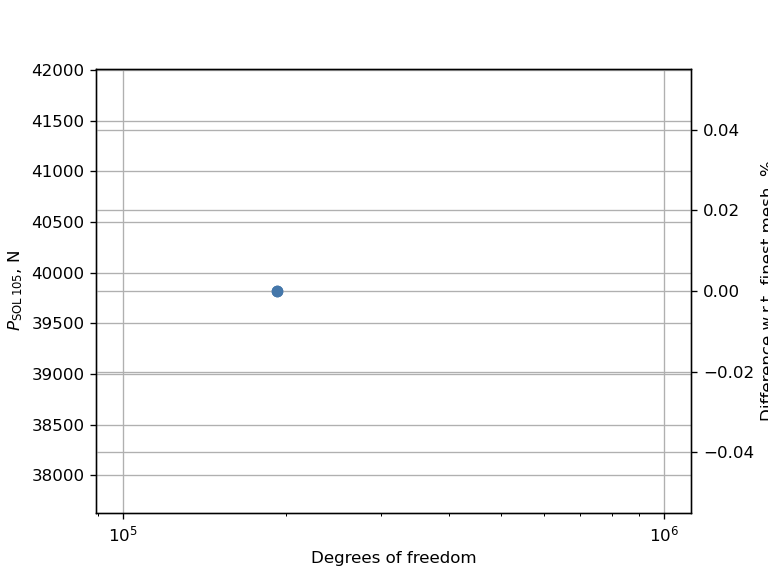

In [6]:
# Plot buckling loads vs degrees of freedom with a log scale along the x-axis
fig, ax1 = plt.subplots()  # create a figure and set of axes
buckling_load_line = ax1.semilogx(dofs, sol_105_buckling_loads, 'o-')

# Create a twin set of axes to plot percentage difference vs degrees of freedom
ax2 = ax1.twinx()
percentage_diff = (sol_105_buckling_loads/sol_105_buckling_loads[-1]-1)*100
percentage_diff_line = ax2.plot(dofs, percentage_diff, 'o-')

# Set plot appearance
ax1.set_xlabel("Degrees of freedom")
ax1.set_ylabel("$P_\mathrm{SOL\,105}$, N")
ax2.set_ylabel("Difference w.r.t. finest mesh, %")
ax1.grid(True)
ax2.grid(True)
plt.show()

We see that the linear buckling load converges to a value just below 40000 N. We define the mesh to be converged when the linear buckling load is within 1% of the value obtained with the finest mesh.

In [7]:
converged_mesh_index = np.where(np.abs(percentage_diff) < 1)[0][0]  # find index corresponding to first percentage difference below 1
element_length_converged_mesh = np.round(shell_element_lengths[converged_mesh_index], 1)  # store shell length of converged mesh
no_elements_converged_mesh = no_elements[converged_mesh_index]  # store number of elements of converged mesh
linear_buckling_load = np.round(sol_105_buckling_loads[converged_mesh_index])  # store buckling load of converged mesh approximating to the nearest integer
print(f"""
The mesh is converged for a target shell element length of {element_length_converged_mesh:.1f} mm,
corresponidng to {no_elements_converged_mesh} elements, {dofs[converged_mesh_index]} degrees of freedom
and to a linear buckling load of {linear_buckling_load:.0f} N.""")


The mesh is converged for a target shell element length of 112.6 mm,
corresponidng to 33120 elements, 192348 degrees of freedom
and to a linear buckling load of 39820 N.


### Mesh convergence verification <a name="mesh-verification"></a>

Similarly to our previous notebooks, we want to verify the convergence of the mesh for the nonlinear structural stability response. We perform this verification by running a nonlinear analysis employing the converged mesh and another nonlinear analysis employed a refined mesh. The refined mesh is obtained by halving the target element length corresponding to the converged mesh. If the two analyses result in approximately the same nonlinear structural stability response we can conclude that the mesh obtained from the mesh convergence study is adequate also for the nonlinear analysis.

We start by running the first nonlinear analysis employing the converged mesh. We create the mesh and the `BDF` object, define the nonlinear analysis parameters to adapt the arc-length increment size and follow the equilibrium path with a fine resolution where needed, and apply twice the linear buckling load found with the mesh convergence study. Compared to our last notebook, we increase the maximum number of increments to 450 to prevent the analysis from stopping before reaching the prescribed load. We finally run the nonlinear analysis calling the function `run_sol_106_with_kllrh_eigenvalues` from the `pynastran_utils` module. To assess the structural stability response we monitor the 20 smallest magnitude eigenvalues of the tangent stiffness matrix.

In [8]:
# Create mesh with converged target element length
original_mesh = box_beam_utils.mesh_reinforced_box_beam_with_curved_skins(
        width=W, height=H, arc_height=H_A, ribs_y_coordinates=RIBS_Y_LOCATIONS, stiffeners_x_coordinates=STIFFENERS_X_LOCATIONS,
        stiffeners_height=H_S, element_length=element_length_converged_mesh)

# Create BDF obejct
nodes_xyz_array = original_mesh.points
nodes_connectivity_matrix = original_mesh.faces.reshape(-1, 5)[:, 1:]
base_bdf = box_beam_utils.create_base_bdf_input(E, NU, RHO, t_0, nodes_xyz_array, nodes_connectivity_matrix, parallel=True)

# Setup SOL 106 with arc-length method using parameters for fine resolution of equilibrium path
sol_106_bdf = base_bdf.__deepcopy__({})
pynastran_utils.set_up_arc_length_method(
        bdf=sol_106_bdf, max_iter=3, conv='PU', eps_u=1e-5, eps_p=1e-5, max_bisect=20, minalr=1e-5, desiter=4, maxinc=450)

# Apply twice the linear buckling load
apply_bending_torsion_load(sol_106_bdf, original_mesh)  # add FORCE cards to define the elliptical load
scale_factor = linear_buckling_load*2  # scale factor to apply to the load set
sol_106_bdf.add_load(sid=LOAD_SET_ID, scale=1., scale_factors=[scale_factor], load_ids=[FORCE_SET_ID])  # add LOAD card
pynastran_utils.create_static_load_subcase(bdf=sol_106_bdf, subcase_id=FIRST_SUBCASE_ID, load_set_id=LOAD_SET_ID)  # create subcase with static load

# Run nonlinear analysis
key = "original mesh"  # key to be used to store the results of the nonlinear analysis
input_name_dict = {key: f"sol_106_{no_elements_converged_mesh}_elements"}  # initialize dictionary with input names of nonlinear analyses
sol_106_op2_dict = {key: pynastran_utils.run_sol_106_with_kllrh_eigenvalues(
    bdf=sol_106_bdf, method_set_id=METHOD_SET_ID, no_eigenvalues=NO_EIGENVALUES,
    analysis_directory_path=ANALYSIS_DIRECTORY_PATH, input_name=input_name_dict[key], upper_eig=UPPER_EIGENVALUE,
    run_flag=False)}

subcase=0 already exists...skipping


Nastran job sol_106_33120_elements.bdf completed
Wall time: 28432.0 s


Now we halve the target length of the shell elements to create the refined mesh and we run the same nonlinear analysis.

In [9]:
# Create mesh with half of the converged target element length
refined_mesh = box_beam_utils.mesh_reinforced_box_beam_with_curved_skins(
        width=W, height=H, arc_height=H_A, ribs_y_coordinates=RIBS_Y_LOCATIONS, stiffeners_x_coordinates=STIFFENERS_X_LOCATIONS,
        stiffeners_height=H_S, element_length=element_length_converged_mesh/2)

# Create BDF object
refined_mesh_bdf = box_beam_utils.create_base_bdf_input(
        E, NU, RHO, t_0, refined_mesh.points, refined_mesh.faces.reshape(-1, 5)[:, 1:], parallel=True)

# Create static load subcase with twice the buckling load predicted by SOL 105
apply_bending_torsion_load(refined_mesh_bdf, refined_mesh)
refined_mesh_bdf.add_load(sid=LOAD_SET_ID, scale=1., scale_factors=[scale_factor], load_ids=[FORCE_SET_ID])
pynastran_utils.create_static_load_subcase(
        bdf=refined_mesh_bdf, subcase_id=FIRST_SUBCASE_ID, load_set_id=LOAD_SET_ID)

# Setup SOL 106 with arc-length method using parameters for fine resolution of equilibrium path
pynastran_utils.set_up_arc_length_method(
        bdf=refined_mesh_bdf, max_iter=3, conv='PU', eps_u=1e-5, eps_p=1e-5, max_bisect=20, minalr=1e-5, desiter=4, maxinc=450)

# Run analysis
no_elements_refined_mesh = len(refined_mesh_bdf.elements)
key = "refined mesh"
input_name_dict[key] = f"sol_106_{no_elements_refined_mesh}_elements"
sol_106_op2_dict[key] = pynastran_utils.run_sol_106_with_kllrh_eigenvalues(
    bdf=refined_mesh_bdf.__deepcopy__({}), method_set_id=METHOD_SET_ID, no_eigenvalues=NO_EIGENVALUES,
    analysis_directory_path=ANALYSIS_DIRECTORY_PATH, input_name=input_name_dict[key], upper_eig=UPPER_EIGENVALUE, run_flag=False)

subcase=0 already exists...skipping


Nastran job sol_106_108276_elements.bdf completed
Wall time: 150505.0 s


We make the first comparison between the two analyses by plotting the eigenvalues of the tangent stiffness matrix against the nondimensional applied load.

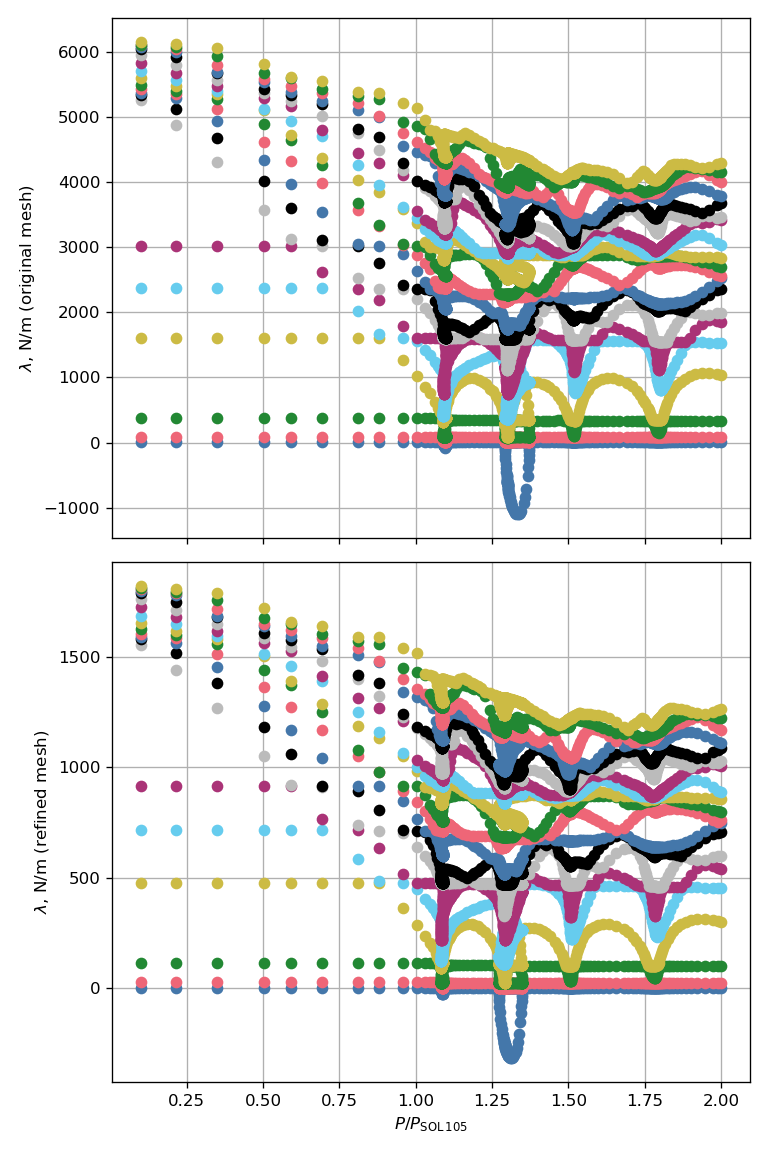

In [10]:
# Initialize dictionaries to store nondimensional applied loads and eigenvalues of tangent stiffness matrix
nondimensional_loads_dict = {}
eigenvalues_dict = {}

# Loop over the two models and read applied loads and eigenvalues
for key in sol_106_op2_dict:
    _, loads, _ = pynastran_utils.read_load_displacement_history_from_op2(op2=sol_106_op2_dict[key])  # read applied loads from OP2 object
    nondimensional_loads_dict[key] = loads[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/linear_buckling_load  # nondimensionalize applied loads with buckling load of model with original mesh
    f06_path = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name_dict[key] + '.f06')  # path of f06 file
    eigenvalues_dict[key] = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)  # read eigenvalues from f06 file

# Plot the eigenvalue diagram for both models
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6.4, 4.8*2))  # create a figure with two axes
for count, key in enumerate(input_name_dict):  # iterate over the two models
    plot_utils.plot_eigenvalue_diagram(nondimensional_loads_dict[key], eigenvalues_dict[key]*1e3, axes[count])  # convert eigenvalues from N/mm to N/m
    axes[count].set_ylabel(f"$\lambda$, N/m ({key})")  # set y-axis label

# Finalize plot appearance
axes[count].set_xlabel("$P/P_\mathrm{SOL\/105}$")
plt.tight_layout()
plt.show()

The results of the two analyses appear to be in good agreement. In addition, they are also very similar to the results obtained in our last notebook, depicting also in this case two region of instabilities, the first weaker and the second stronger.

We calculate the percentagge difference of the load where the first instability occurs between the two meshes.

In [11]:
print("Nondimensional applied load at first instability:")
nondimensional_load_first_instability = {}  # initialize dictionary to store nondimensional applied load at first limit point
for key in nondimensional_loads_dict:  # loop through the load history of the two meshes
    first_negative_eigenvalue_index = np.where(eigenvalues_dict[key][0] < 0)[0][0]  # find index of first negative eigenvalue
    nondimensional_load_first_instability[key] = nondimensional_loads_dict[key][first_negative_eigenvalue_index]  # store nondimensional applied load at first limit point
    print(f"- {key}: {nondimensional_load_first_instability[key]:.2f}")  # print nondimensional applied load at first limit point
percentage_diff = (nondimensional_load_first_instability["original mesh"]/
                   nondimensional_load_first_instability["refined mesh"] - 1)*100  # compute percentage difference
print(f"\nPercentage difference of original mesh w.r.t. refined mesh: {percentage_diff:.1f} %")  # print percentage difference

Nondimensional applied load at first instability:
- original mesh: 1.10
- refined mesh: 1.09

Percentage difference of original mesh w.r.t. refined mesh: 0.7 %


The percentage difference is smaller than 1%, confirming that the mesh obtained from the mesh convergence study is adequate for the scope of capturing the first instability of the CRM-like Box Beam.

The next step of our verification is to compare the load-displacement curves obtained from the two analyses. Similarly to our previous notebooks,we are going to compare two 3D load-displacement curves, where we are going to visualize the applied load against the tip displacement and the local out-of-plane displacement in the root region of the top skin.

First we find the node associated to the tip of the CRM-like Box Beam in both models.

In [12]:
tip_node_xyz = np.array([W/2, L, 0])  # tip node is taken at the center of the tip rib
tip_node_id_dict = {"original mesh": np.argmin(np.linalg.norm(original_mesh.points - tip_node_xyz, axis=1)) + 1,
                    "refined mesh": np.argmin(np.linalg.norm(refined_mesh.points - tip_node_xyz, axis=1)) + 1}

To plot the local displacement over the root region of the top skin we need to find the node where the linear buckling analysis predicts the largest displacement of the critical buckling mode. For the model with the converged mesh we only need to read the op2 file of the analysis that we run during the mesh convergence study, while for the model with the refined mesh we need to run a new linear buckling analysis. For the latter case, we plot the critical buckling mode highlighting the node of interest.

subcase=1 already exists...skipping


Nastran job sol_105_108276_elements.bdf completed
Wall time: 67.0 s
Critical buckling mode of refined mesh:


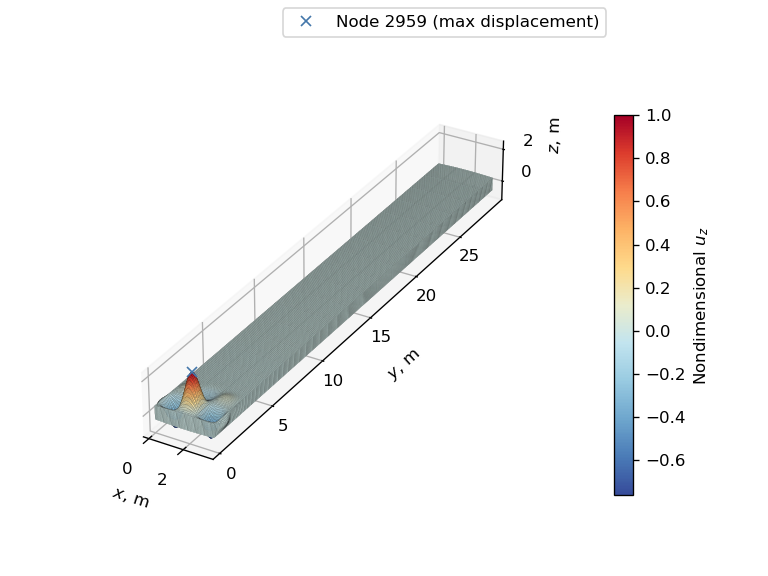

In [13]:
from pyNastran.op2.op2 import read_op2  # import function to read op2 file

# Read op2 file of SOL 105 analysis with original mesh
key = "original mesh"
input_name = f"sol_105_{no_elements_converged_mesh}_elements"
sol_105_op2 = read_op2(op2_filename=os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.op2'), load_geometry=True, debug=None)

# Find id of node where maximum displacement occurs
max_displacement_index = np.argmax(
        np.linalg.norm(sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].data[0, :, 0:3], axis=1))  # find index of max displacement magnitude
root_node_id_dict = {key: sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].node_gridtype[max_displacement_index, 0]}  # store id of node where max displacement occurs in dictionary

# Run SOL 105 for model with refined mesh
key = "refined mesh"
input_name = f"sol_105_{no_elements_refined_mesh}_elements"
sol_105_op2 = pynastran_utils.run_sol_105(
    bdf=refined_mesh_bdf, static_load_set_id=FORCE_SET_ID, analysis_directory_path=ANALYSIS_DIRECTORY_PATH, input_name=input_name,
    run_flag=False)

# Plot critical buckling mode
print(f"Critical buckling mode of {key}:")
amplification_factor = 2  # amplification factor for displacements
_, ax, cbar = plot_utils.plot_eigenvector(
    op2=sol_105_op2, subcase_id=SECOND_SUBCASE_ID, displacement_component='tz', colormap='sunset',
    displacement_amplification_factor=amplification_factor, unit_scale_factor=LENGTH_SCALE_FACTOR)  # plot buckling mode converting from mm to m
    
# Plot node where max displacement occurs and add node id to dictionary
root_node_id_dict[key] = plot_utils.plot_max_displacement_node(
    axes=ax, op2=sol_105_op2, unit_scale_factor=LENGTH_SCALE_FACTOR, displacement_amplification_factor=amplification_factor)

# Add legend, adjust plot appearance and show plot
ax.legend()
adjust_3d_plot(ax, cbar)
plt.show()

Now we read the root and tip displacement history obtained for both models and we nondimensionalize displacements with the width and the length of the CRM-like Box Beam, respectively. Finally, we plot the 3D load-displacement diagram. We use the function `plot_3d_load_displacements_stability` from the `plot_utils` module to highlight the unstable segments of the equilibrium paths.

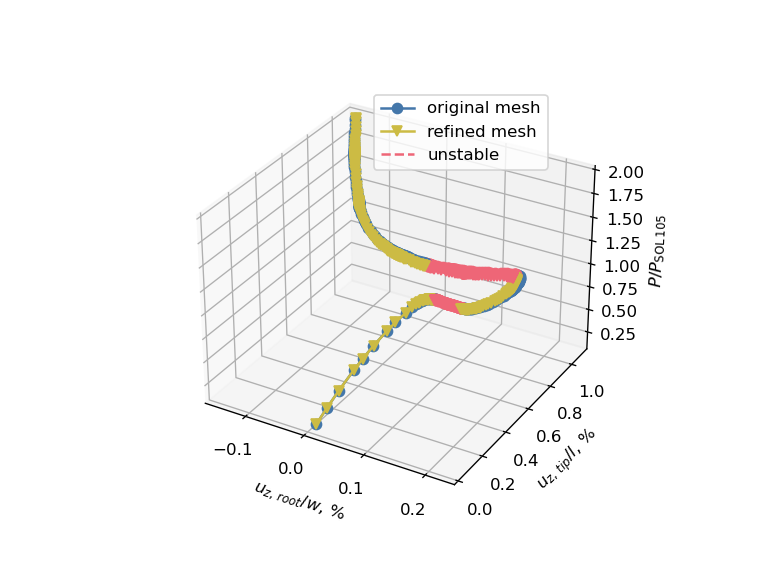

In [14]:
# Initialize dictionaries to store nondimensional root and tip displacements
nondimensional_root_displacments = {}
nondimensional_tip_displacments = {}

# Loop over the analyses of the two meshes and read the displacement history
for key in sol_106_op2_dict:
    _, _, displacements = pynastran_utils.read_load_displacement_history_from_op2(
        op2=sol_106_op2_dict[key], node_ids=[root_node_id_dict[key], tip_node_id_dict[key]])
    nondimensional_root_displacments[key] = displacements[root_node_id_dict[key]][FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/W
    nondimensional_tip_displacments[key] = displacements[tip_node_id_dict[key]][FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/L
    
# Create 3D plot of load-displacement diagram
fig = plt.figure()  # create a figure
ax_3d = plt.axes(projection="3d")  # create 3D axes
stable_lines = []  # list to store proxy artists for the legend

# Loop over the two meshes and plot the load-displacement diagram
for count, key in enumerate(nondimensional_root_displacments):
    # Plot load-displacement curve
    plot_utils.plot_3d_load_displacements_stability(
        axes=ax_3d,
        displacements1=nondimensional_root_displacments[key]*100,
        displacements2=nondimensional_tip_displacments[key]*100,
        loads=nondimensional_loads_dict[key],
        eigenvalues=eigenvalues_dict[key],
        marker=MARKERS[count], color=COLORS[count])
    # Add proxy artist for the legend
    stable_lines.append(Line2D([0], [0], linestyle='-', marker=MARKERS[count], color=COLORS[count], label=key))

# Add proxy artist for unstable lines and create legend
unstable_line = Line2D([0], [0], linestyle='--', color=UNSTABLE_COLOR, label="unstable")
fig.legend(handles=stable_lines + [unstable_line], loc="upper center", bbox_to_anchor=(0.6, 0.85))

# Set plot appearance
ax_3d.set_xlabel("$u_{z,\,root}/w$, %")
ax_3d.set_ylabel("$u_{z,\,tip}/l$, %")
ax_3d.set_zlabel("$P/P_\mathrm{SOL\/105}$")
ax_3d.grid(visible=True)
plt.show()

The load-displacement diagram above shows that the two analyses are in good agreement. The two paths are almost identical, showing the same two regions of instabilities, the first weaker and the second stronger. These results confirm that the mesh obtained from the mesh convergence study is adequate to capture the nonlinear structural stability response of the CRM-like Box Beam subjected to a combined bending and torsional load.

## Linear Buckling Optimization <a name="linear"></a>

***

We set up the OpenMDAO problem for linear buckling optimization with two design variables, the root and tip thickness, that are linearly interpolated to the design segments of the CRM-like Box Beam. Similarly to our previous notebooks, we use the linear buckling load of the initial structure as the design load.

In [15]:
from resources import optimization_utils  # import optimization_utils module from resources folder
import openmdao.api as om  # make available the most common OpenMDAO classes and functions

# Create base bdf object
sol_105_bdf = box_beam_utils.create_base_bdf_input(E, NU, RHO, t_0, nodes_xyz_array, nodes_connectivity_matrix, parallel=True)
    
# Define property segments
box_beam_utils.define_property_segments(bdf=sol_105_bdf, ribs_y_locations=RIBS_Y_LOCATIONS)

# Apply bending and torsion load
apply_bending_torsion_load(sol_105_bdf, original_mesh)

# Define load set with design load equal to the linear buckling load
design_load = linear_buckling_load
sol_105_bdf.add_load(sid=LOAD_SET_ID, scale=1., scale_factors=[design_load], load_ids=[FORCE_SET_ID])  # add LOAD card

# Set up SOL 105 analysis
pynastran_utils.set_up_sol_105(bdf=sol_105_bdf, static_load_set_id=LOAD_SET_ID, no_eigenvalues=NO_EIGENVALUES)

# Request stress results of all elements in the op2 file
sol_105_bdf.case_control_deck.subcases[0].add_result_type('STRESS', 'ALL', ['PLOT'])  # store stress results of all elements in the op2 file

# Define NastranGroup object
input_name = "sol_105_linear_opt_start"  # default name of input file
sol_105_group = optimization_utils.NastranGroup(
    bdf=sol_105_bdf, yield_strength=SIGMA_Y, analysis_directory_path=ANALYSIS_DIRECTORY_PATH, input_name=input_name, run_flag=False)  # create NastranGroup object

# Define spline component and connect it to the NastranSolver component
box_segments_eval_y_locations = RIBS_Y_LOCATIONS[0:-1] + np.ediff1d(RIBS_Y_LOCATIONS)/2  # y-coordinates of the thickness evaluation points for each box segment
x_interp = np.sort(np.concatenate((RIBS_Y_LOCATIONS, box_segments_eval_y_locations)))  # combine and sort the y-coordinates of the control points of the stiffened box patches and the ribs
interp_comp = om.SplineComp(method='slinear', x_cp_val=np.array([0, L]), x_interp_val=x_interp)  # create linear spline component
interp_comp.add_spline(y_cp_name='t_cp', y_interp_name='t_val')  # add spline variables to the component
sol_105_group.add_subsystem('interp', interp_comp)  # add spline component to the group
sol_105_group.connect('interp.t_val', 'nastran_solver.t_val')  # connect spline component output to the NastranSolver component input

# Set up OpenMDAO problem
linear_problem = om.Problem(model=sol_105_group, name="sol_105")
linear_problem.setup()

subcase=0 already exists...skipping


We assign the initial constant thickness distribution and we run the analysis to record the objective and the constraint functions of the initial design.

In [16]:
# Assign initial thickness and run model
initial_thickness_vector = t_0*np.ones(2)  # constant initial thickness
linear_problem.set_val('interp.t_cp', initial_thickness_vector)  # assign initial thickness vector to input of spline component
linear_problem.run_model()  # run the model

# Store and print initial mass and KS values
mass_0 = linear_problem['nastran_solver.mass'][0]
ks_buckling_0 = linear_problem['nastran_solver.ks_buckling'][0]
ks_stress_0 = linear_problem['nastran_solver.ks_stress'][0]
print("Initial thickness vector [mm]:")
print(initial_thickness_vector)
print(f"""Initial KS value for buckling load factor: {ks_buckling_0:.3f}
Initial KS value for stress: {ks_stress_0:.0f} MPa
Initial mass: {mass_0*1e3:.0f} kg""")

Nastran job sol_105_linear_opt_start.bdf completed
Wall time: 23.0 s
Initial thickness vector [mm]:
[7.7 7.7]
Initial KS value for buckling load factor: 0.000
Initial KS value for stress: -392 MPa
Initial mass: 6617 kg


We define the initial design vector, the default input name of the analysis, choose COBYLA as optimization algorithm, add design variables, objective and constraints to the `Problem` object and add a recorder to the optimizer to store the optimization history. Finally, we run the optimization and we visualize the convergence history.

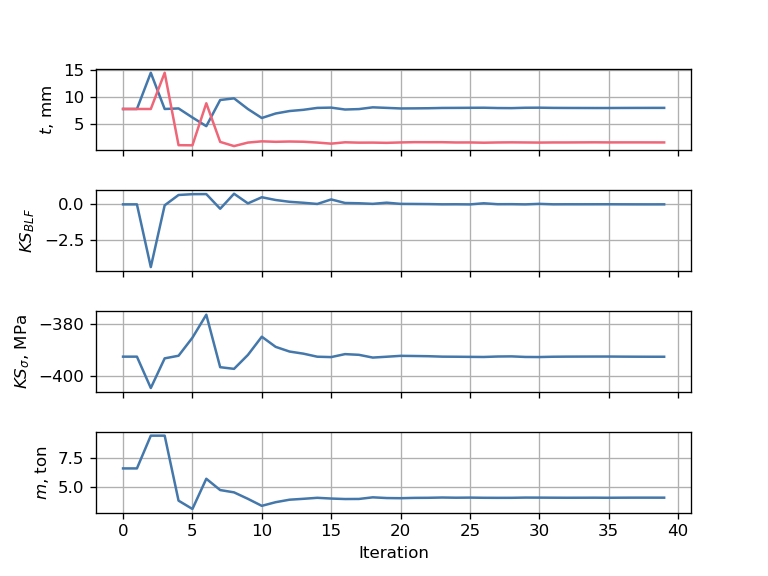

Design variables, constraints and objective at last iteration:
- interp.t_cp: [7.9046 1.5097]
- nastran_solver.ks_buckling: [0.001]
- nastran_solver.ks_stress: [-392.5004]
- nastran_solver.mass: [4.045]


In [17]:
# Set default initial thickness vector and name of input file
linear_problem.model.set_input_defaults('interp.t_cp', initial_thickness_vector)
input_name = "sol_105_linear_opt"  # default name of input file employed during optimization
linear_problem.model.options['input_name'] = "sol_105_linear_opt"  # change default name of input file

# Choose optimizer
linear_problem.driver = om.ScipyOptimizeDriver()
linear_problem.driver.options['optimizer'] = 'COBYLA'
linear_problem.driver.options['tol'] = OPTIMIZER_TOLERANCE

# Add design variable, objective and constraints
thickness_bounds = [1., 20.]  # [mm]
linear_problem.model.add_design_var(
    'interp.t_cp', lower=thickness_bounds[0], upper=thickness_bounds[1], ref0=thickness_bounds[0], ref=t_0)  # scale thickness so that the lower bound is 0 and initial value is 1
linear_problem.model.add_objective('nastran_solver.mass', ref0=mass_0/2, ref=mass_0)  # scale mass so that half of the initial mass is 0 and the initial mass is 1
linear_problem.model.add_constraint('nastran_solver.ks_buckling', upper=0.)  # KS function for buckling load factor is not scaled because buckling load factor is already a ratio
linear_problem.model.add_constraint('nastran_solver.ks_stress', upper=0., ref=np.abs(ks_stress_0))  # scale KS function for stresses so that the initial value is 1

# Add recorder to the driver
recorder_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.sql')
recorder = om.SqliteRecorder(recorder_filepath)  # create recorder
linear_problem.driver.add_recorder(recorder)  # attach recorder to the driver

# Run optimization
linear_problem.setup()  # re-setup problem before running optimization
linear_problem.set_solver_print(0)  # disable solver output
linear_problem.driver.options['debug_print'] = ['desvars','nl_cons','objs']  # print design variables, constraints and objectives
if False:  # set True or False to run optimization or not
    linear_problem.run_driver()  # run optimization
linear_problem.cleanup()  # clean up problem

# Plot optimization history and print results
_, linear_opt_histories = optimization_utils.plot_optimization_history(recorder_filepath)  # plot optimization history

We calculate the mass reduction w.r.t. the initial design with constant thickness distribution.

In [18]:
mass_percentage_variation = (linear_opt_histories['nastran_solver.mass'][-1, 0]/mass_0 - 1)*100
print(f"Mass variation w.r.t. initial structure: {mass_percentage_variation:.1f} %")

Mass variation w.r.t. initial structure: -38.9 %


We plot the critical buckling mode of the linearly optimized structure.

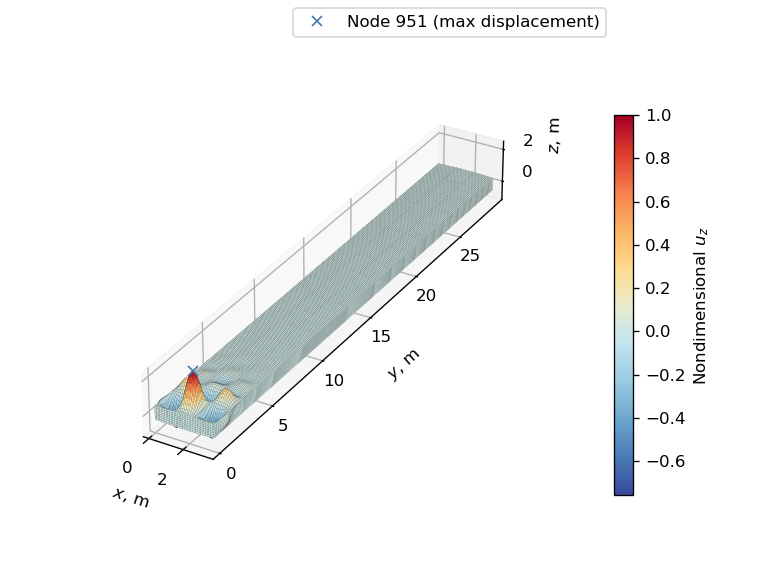

In [19]:
# Read op2 file of analysis of optimized structure
sol_105_op2 = read_op2(os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.op2'), load_geometry=True, debug=None)

# Plot critical buckling mode and highlight max displacement node
_, ax, cbar = plot_utils.plot_eigenvector(
    op2=sol_105_op2, subcase_id=SECOND_SUBCASE_ID, displacement_component='tz', colormap='sunset',
    displacement_amplification_factor=amplification_factor, unit_scale_factor=LENGTH_SCALE_FACTOR)  # convert from mm to m
max_displacement_node_id = plot_utils.plot_max_displacement_node(
    axes=ax, op2=sol_105_op2, unit_scale_factor=LENGTH_SCALE_FACTOR, displacement_amplification_factor=amplification_factor)
ax.legend()
adjust_3d_plot(ax, cbar)
plt.show()

The critical buckling mode of the linearly optimized structure is basically the same of that of the initial structure.

### Nonlinear response of linearly optimized structure

We set up the OpenMDAO problem for the nonlinear analysis to assess the nonlinear structural stability response of the linearly optimized structure.

In [20]:
# Define property segments
box_beam_utils.define_property_segments(bdf=sol_106_bdf, ribs_y_locations=RIBS_Y_LOCATIONS)

# Request nonlinear stress results of all elements in the op2 file
sol_106_bdf.case_control_deck.subcases[0].add_result_type('NLSTRESS', 'ALL', ['PLOT'])

# Create NastranGroup object
input_name = "sol_106_linear_opt"
sol_106_group = optimization_utils.NastranGroup(
    bdf=sol_106_bdf, yield_strength=SIGMA_Y, eigenvalue_scale_factor=EIGENVALUE_SCALE_FACTOR,
    analysis_directory_path=ANALYSIS_DIRECTORY_PATH, input_name=input_name, run_flag=False)  # create NastranGroup object

# Add spline component and connect it to the NastranSolver component
sol_106_group.add_subsystem('interp', interp_comp)
sol_106_group.connect('interp.t_val', 'nastran_solver.t_val')

# Set up optimization problem
nonlinear_problem = om.Problem(model=sol_106_group, name="sol_106")
nonlinear_problem.setup()

We apply twice the design load, assign the linearly optimized thickness distribution and run the analysis.

In [21]:
sol_106_bdf.load_combinations[LOAD_SET_ID][0].scale_factors[0] = design_load*2  # scale load to twice the design load
linear_opt_thickness_vector = linear_opt_histories['interp.t_cp'][-1, :]
nonlinear_problem.set_val('interp.t_cp', linear_opt_thickness_vector)  # assign thickness array to spline component input
nonlinear_problem.run_model()  # run analysis

Nastran job sol_106_linear_opt.bdf completed
Wall time: 37022.0 s


We plot the eigenvalues of the tangent stiffness matrix.

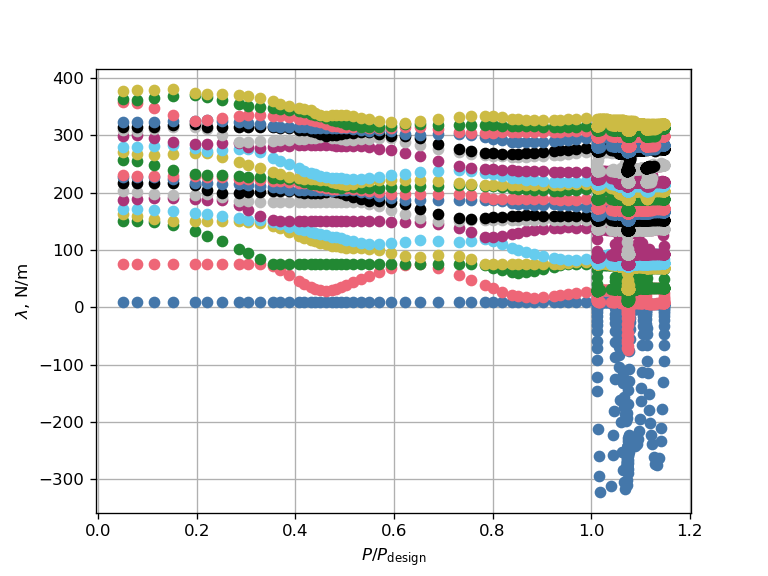

In [22]:
# Read load and displacement history from op2 file
sol_106_op2 = nonlinear_problem['nastran_solver.op2']  # retrieve op2 object
monitor_node_ids = [root_node_id_dict["original mesh"], tip_node_id_dict["original mesh"]]  # list of node ids to plot
_, loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(op2=sol_106_op2, node_ids=monitor_node_ids)
nondimensional_loads = loads[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/design_load  # nondimensionalize loads

# Read eigenvalues of tangent stiffness matrix
f06_path = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.f06')  # path to .f06 file
eigenvalues = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)

# Plot eigenvalues vs applied load
_, ax = plot_utils.plot_eigenvalue_diagram(nondimensional_loads, eigenvalues*EIGENVALUE_SCALE_FACTOR)
ax.set_ylabel("$\lambda$, N/m")
ax.set_xlabel("$P/P_\mathrm{design}$")
plt.show()

We observe that the analysis did not converge to the prescribed load because it reached the maximum number of allowed increments. We also observe that the structure loses stability several times above the design load. We find the nondimensional load where the first instability occurs.

In [23]:
first_negative_eigenvalue_index = np.where(eigenvalues[0] < 0)[0][0]  # find index of first negative eigenvalue
nondimensional_load_first_instability = nondimensional_loads[first_negative_eigenvalue_index]  # store nondimensional applied load at first limit point
print(f"Nondimensional applied load at first instability: {nondimensional_load_first_instability:.2f}")

Nondimensional applied load at first instability: 1.05


We plot the eigenvalues of the tangent stiffness matrix against the cumulative sum of the absolute value of the load increments, to get a better visualization of the number of unstable regions found during the analysis.

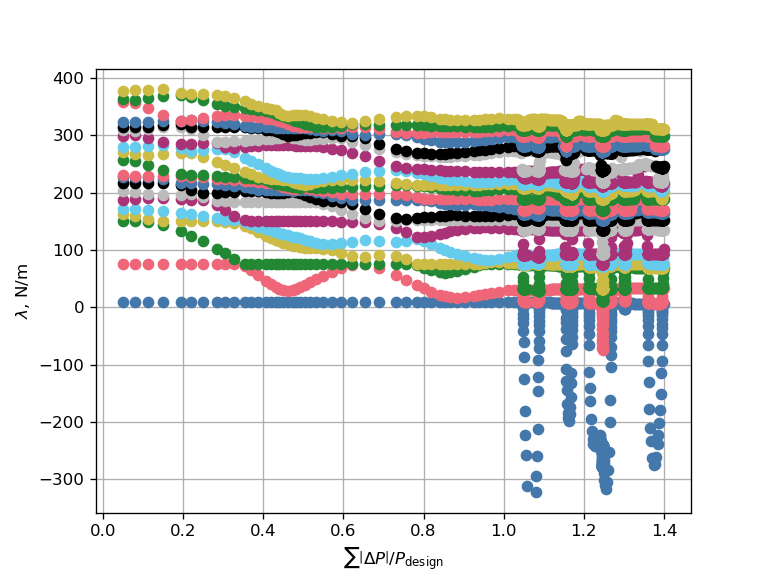

In [24]:
_, ax = plot_utils.plot_eigenvalue_diagram(nondimensional_loads, eigenvalues*EIGENVALUE_SCALE_FACTOR, cum_loads=True)
ax.set_ylabel("$\lambda$, N/m")
ax.set_xlabel(r"$\sum \left|\Delta P\right|/P_\mathrm{design}$")
plt.show()

We can observe five different unstable regions.

We plot load-displacement diagram inspecting the $z$-displacement of the root node of the top skin and the tip displacement.

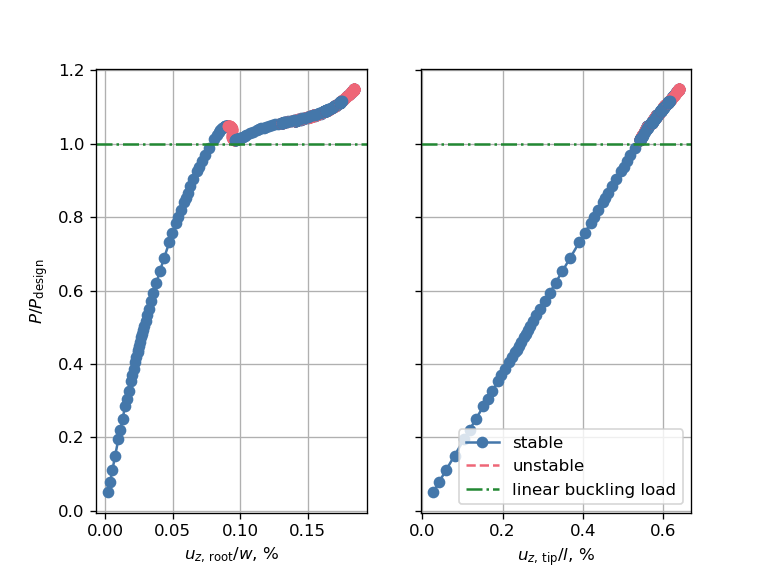

In [25]:
# Plot load-displacement diagrams of the initial and linearly optimized structures
fig, axes = plt.subplots(1, 2, sharey=True)  # create a figure with two subplots
displacement_labels = ["root", "tip"]  # labels for the displacements
reference_lengths = [W, L]  # reference lengths for the displacements
reference_lengths_labels = ["w", "l"]  # labels for the reference lengths
for i, displacement_key in enumerate(displacements):  # loop through the displacements
    plot_utils.plot_2d_load_displacements_stability(
        axes[i],
        displacements[displacement_key][FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/reference_lengths[i]*100,
        nondimensional_loads,
        eigenvalues,
        MARKERS[0], COLORS[0])  # plot load-displacement curve
    axes[i].axhline(y=1, color=LINEAR_BUCKLING_COLOR, linestyle='-.')  # plot glass ceiling of linear buckling
    axes[i].set_xlabel(f"$u_{{z,\,\mathrm{{{displacement_labels[i]}}}}}/{reference_lengths_labels[i]}$, %")  # set x-axis label
    axes[i].grid(visible=True)

# Create proxy artists for the legend and add legend
stable_line = Line2D([0], [0], linestyle='-', marker=MARKERS[0], color=COLORS[0], label="stable")
linear_buckling_line = Line2D([0], [0], linestyle='-.', color=LINEAR_BUCKLING_COLOR, label="linear buckling load")
axes[1].legend(handles=[stable_line, unstable_line, linear_buckling_line])

# Add y-axis label and show plot
axes[0].set_ylabel("$P/P_\mathrm{design}$")
plt.show()

The first instability is evident in the root displacement plot, while the others are not clearly visible, most likely because they involve another part of the top skin.

## Nonlinear Structural Stability Optimization <a name="nonlinear"></a>

***

We apply the design load and run the analysis for the initial design to record the constraint and objective functions.

In [26]:
# Scale load to design load, change DMAP and run model
sol_106_bdf.load_combinations[LOAD_SET_ID][0].scale_factors[0] = design_load  # scale load to design load
dmap_stop = sol_106_bdf.executive_control_lines[1].replace("nobuckle", "stop")  # get include string for DMAP stopping the analysis after the first negative eigenvalue is found
sol_106_bdf.executive_control_lines[1] = dmap_stop  # change DMAP command to store eigenvectors
nonlinear_problem.model.nastran_solver.options['input_name'] = "sol_106_nonlinear_opt_start"
sol_106_bdf.nlpcis[1].mxinc = 200  # decrease maximum number of increments to speed up optimization
nonlinear_problem.run_model()

# Store and print initial KS values and mass
ks_stability_0 = nonlinear_problem["nastran_solver.ks_stability"][0]
ks_stress_0 = nonlinear_problem["nastran_solver.ks_stress"][0]
mass_0 = nonlinear_problem['nastran_solver.mass'][0]
print(f"""Initial KS value for stability: {ks_stability_0:.3f} N/m
Initial KS value for stress: {ks_stress_0:.0f} MPa
Initial mass: {mass_0*1e3:.0f} kg""")

Nastran job sol_106_nonlinear_opt_start.bdf completed
Wall time: 1244.0 s
Initial KS value for stability: -9.013 N/m
Initial KS value for stress: -392 MPa
Initial mass: 4045 kg


We set up the optimization similarly to what done for the linear buckling optimization and we run the optimization.

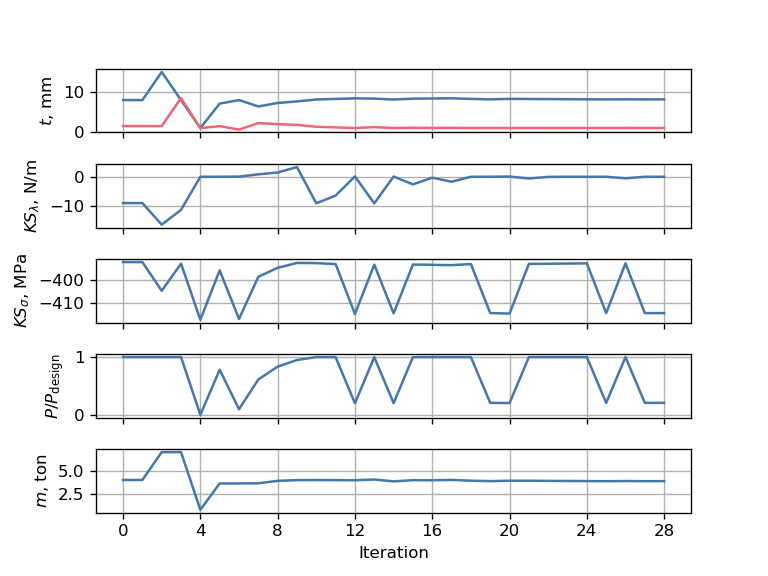

Design variables, constraints and objective at last iteration:
- interp.t_cp: [8.0798 1.0439]
- nastran_solver.ks_stability: [0.0047]
- nastran_solver.ks_stress: [-414.1755]
- nastran_solver.load_factor: [0.2155]
- nastran_solver.mass: [3.9201]


In [27]:
# Set default input values of sol_106 component
nonlinear_problem.model.set_input_defaults('interp.t_cp', linear_opt_thickness_vector)
input_name = "sol_106_nonlinear_opt"
nonlinear_problem.model.options['input_name'] = input_name

# Choose optimizer
nonlinear_problem.driver = om.ScipyOptimizeDriver()
nonlinear_problem.driver.options['optimizer'] = 'COBYLA'
nonlinear_problem.driver.options['tol'] = OPTIMIZER_TOLERANCE

# Add design variable, objective and constraints
nonlinear_problem.model.add_design_var(
    'interp.t_cp', lower=thickness_bounds[0], upper=thickness_bounds[1], ref0=thickness_bounds[0], ref=linear_opt_thickness_vector[0])  # scale thickness so that the lower bound is 0 and initial value at root is 1
nonlinear_problem.model.add_objective('nastran_solver.mass', ref0=mass_0/2, ref=mass_0)  # scale mass so that half of the initial mass is 0 and the initial mass is 1
nonlinear_problem.model.add_constraint('nastran_solver.ks_stability', upper=0., ref=np.abs(ks_stability_0))  # scale KS function for nonlinear structural stability so that the initial value is 1
nonlinear_problem.model.add_constraint('nastran_solver.ks_stress', upper=0., ref=np.abs(ks_stress_0))  # scale KS function for stresses so that the initial value is 1
nonlinear_problem.model.add_constraint('nastran_solver.load_factor', lower=.99)  # final applied load should be at least 99% of the design load

# Add recorder
recorder_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.sql')
recorder = om.SqliteRecorder(recorder_filepath)  # create recorder
nonlinear_problem.driver.add_recorder(recorder)  # attach recorder to the driver

# Run optimization
nonlinear_problem.setup()  # re-setup problem
nonlinear_problem.set_solver_print(0)  # disable solver output
nonlinear_problem.driver.options['debug_print'] = ['desvars','nl_cons','objs']  # print design variables, constraints and objectives
if False:  # set True or False to run optimization or not
    nonlinear_problem.run_driver()  # run optimization
nonlinear_problem.cleanup()  # clean up problem

# Plot optimization history and print results
_, nonlinear_opt_histories = optimization_utils.plot_optimization_history(recorder_filepath)  # plot optimization history

The optimization ends on an unfeasible design, as the stability constraint function has a positive value. We find the last feasible design point and print the feasible values of design variables, constraints and objective.

In [28]:
# Find index of last feasible design
feasible_design_index = np.where(nonlinear_opt_histories['nastran_solver.ks_stability'][:, 0] < OPTIMIZER_TOLERANCE)[0][-1]

# Print design variables, constraints and objective at last feasible iteration
print("Design variables, constraints and objective at last feasible iteration:")
for key in nonlinear_opt_histories:
    print(f"- {key}: {nonlinear_opt_histories[key][feasible_design_index]}")

# Find and print mass percentage variation w.r.t. initial structure
mass_percentage_variation = (nonlinear_opt_histories['nastran_solver.mass'][feasible_design_index, 0]/mass_0 - 1)*100
print(f"Mass variation w.r.t. linearly optimized structure: {mass_percentage_variation:.1f} %")

Design variables, constraints and objective at last feasible iteration:
- interp.t_cp: [8.0937 1.0574]
- nastran_solver.ks_stability: [-0.5341]
- nastran_solver.ks_stress: [-393.0112]
- nastran_solver.load_factor: [1.]
- nastran_solver.mass: [3.9318]
Mass variation w.r.t. linearly optimized structure: -2.8 %


We run the analysis at last feasible design point and plot eigenvalues of tangent stiffness matrix.

Nastran job sol_106_nonlinear_opt_feasible.bdf completed
Wall time: 7096.0 s


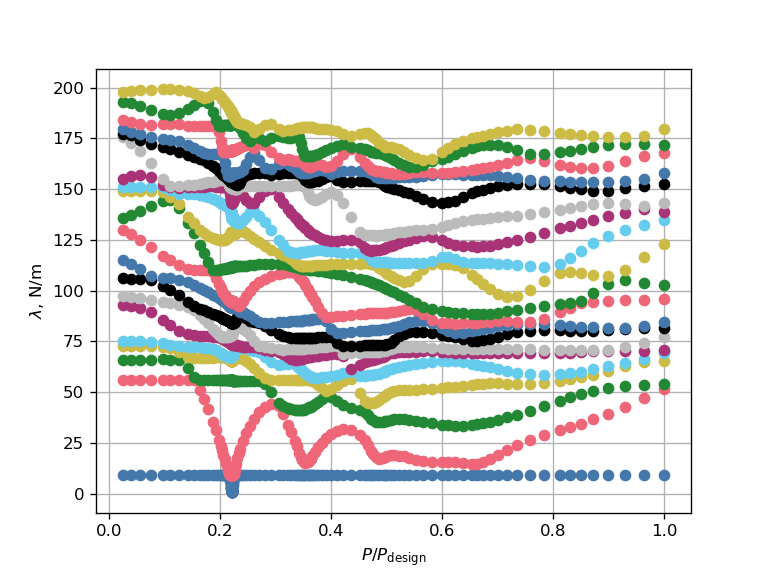

In [29]:
# Run analysis of last feasible design
nonlinear_opt_thickness_vector = nonlinear_opt_histories['interp.t_cp'][feasible_design_index]
nonlinear_problem.set_val('interp.t_cp', nonlinear_opt_thickness_vector)
input_name = "sol_106_nonlinear_opt_feasible"
nonlinear_problem.model.nastran_solver.options['input_name'] = input_name
nonlinear_problem.run_model()

# Read load and displacement history
sol_106_op2 = nonlinear_problem['nastran_solver.op2']
_, loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(
    op2=sol_106_op2, node_ids=monitor_node_ids)
nondimensional_loads = loads[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/design_load  # nondimensionalize loads

# Read eigenvalues of tangent stiffness matrix
f06_path = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.f06')  # path to .f06 file
eigenvalues = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)

# Plot eigenvalues vs applied load
_, ax = plot_utils.plot_eigenvalue_diagram(nondimensional_loads, eigenvalues*EIGENVALUE_SCALE_FACTOR)
ax.set_ylabel("$\lambda$, N/m")
ax.set_xlabel("$P/P_\mathrm{design}$")
ax.grid(visible=True)
plt.show()

We observe a minimum of one eigenvalue at approximately $P/P_\mathrm{design}=0.22$, probably indicating the presence of a broken supercritical pitchfork for one of the skin panels. However, all eigenvalues remain positive and the structure does not lose stability.

We run a linear buckling analysis on the nonlinearly optimized structure and we plot the critical buckling mode.

Nastran job sol_105_nonlinear_opt.bdf completed
Wall time: 29.0 s
P_SOL 105/P_design = 0.40
Critical buckling mode:


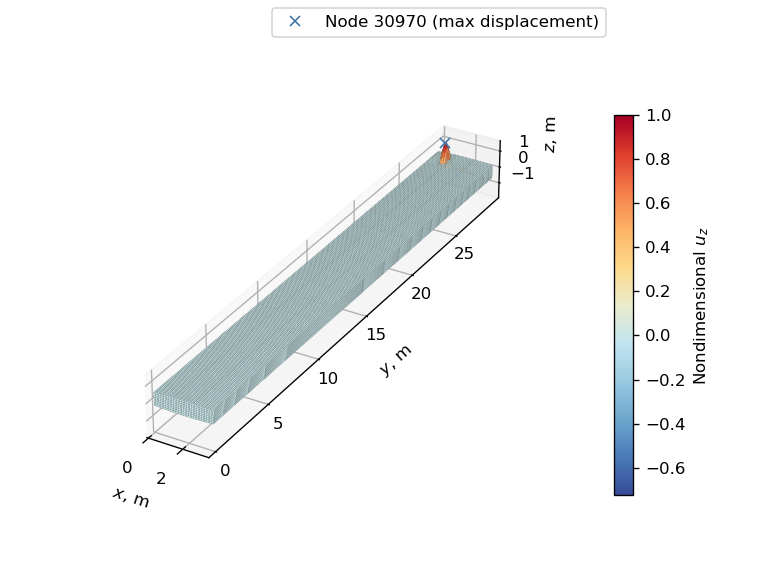

In [30]:
# Modify name of bdf file and input thicknesses and run analysis
linear_problem.model.options['input_name'] = "sol_105_nonlinear_opt"
linear_problem.setup()
linear_problem.set_val('interp.t_cp', nonlinear_opt_thickness_vector)
linear_problem.run_model()

# Retrieve OP2 object of nonlinear analysis and print buckling load
sol_105_op2 = linear_problem['nastran_solver.op2']
nonlinear_opt_blf = sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].eigrs[0]
print(f"P_SOL 105/P_design = {nonlinear_opt_blf:.2f}")

# Plot buckling mode
print("Critical buckling mode:")
amplification_factor = 2  # amplification factor for displacements
_, ax, cbar = plot_utils.plot_eigenvector(
    op2=sol_105_op2, subcase_id=SECOND_SUBCASE_ID, displacement_component='tz', colormap='sunset', length_unit='m',
    displacement_amplification_factor=amplification_factor, unit_scale_factor=LENGTH_SCALE_FACTOR)  # plot buckling mode converting from mm to m
plot_utils.plot_max_displacement_node(axes=ax, op2=sol_105_op2, displacement_amplification_factor=amplification_factor, unit_scale_factor=LENGTH_SCALE_FACTOR)
ax.legend()

# Adjust plot and show
adjust_3d_plot(ax, cbar)
plt.show()

The critical buckling mode of the nonlinearly optimized structure involves the tip of the bottom skin, indicating that for the linear analysis the most critical mode corresponds to a cylindrical shell roof buckling mode. This is probably driven by the very small thickness of the bottom skin in the tip region. 

We plot the load-displacement diagrams visualizing the glass ceiling of linear buckling.

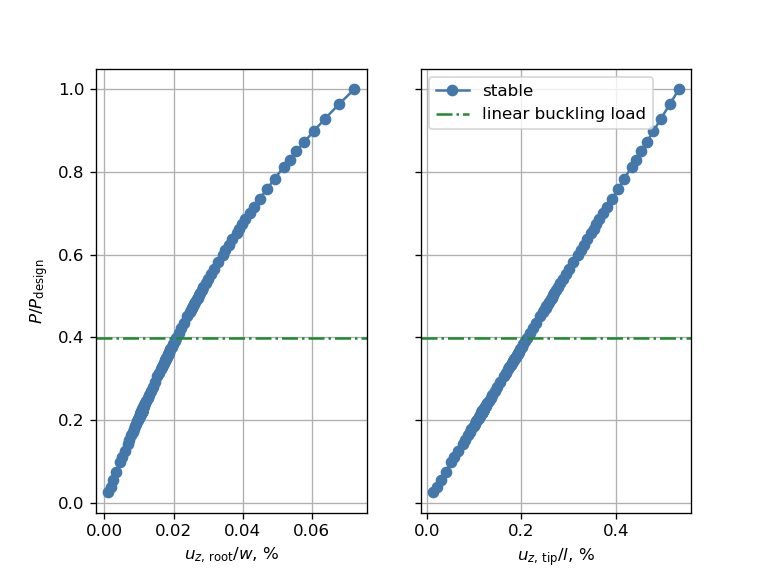

In [31]:
# Plot load-displacement diagrams of the initial and linearly optimized structures
fig, axes = plt.subplots(1, 2, sharey=True)  # create a figure with two subplots
for i, node_id in enumerate(displacements):  # loop through the displacements
    plot_utils.plot_2d_load_displacements_stability(
        axes[i],
        displacements[node_id][FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/reference_lengths[i]*100,
        nondimensional_loads,
        eigenvalues,
        MARKERS[0], COLORS[0])  # plot load-displacement curve
    axes[i].axhline(y=nonlinear_opt_blf, color=LINEAR_BUCKLING_COLOR, linestyle='-.')  # plot glass ceiling of linear buckling
    axes[i].set_xlabel(f"$u_{{z,\,\mathrm{{{displacement_labels[i]}}}}}/{reference_lengths_labels[i]}$, %")  # set x-axis label
    axes[i].grid(visible=True)

# Create proxy artists for the legend and add legend
axes[1].legend(handles=[stable_line, linear_buckling_line])

# Add y-axis label and show plot
axes[0].set_ylabel("$P/P_\mathrm{design}$")
plt.show()

We plot the deformation at the design load.

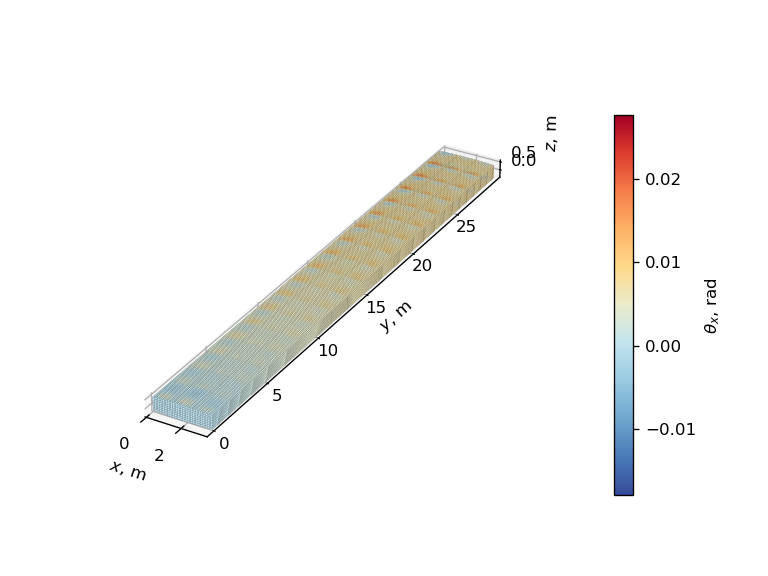

In [32]:
_, ax, cbar = plot_utils.plot_deformation(
    op2=sol_106_op2, displacement_component='rx', colormap='sunset', unit_scale_factor=LENGTH_SCALE_FACTOR)  # plot deformation converting from mm to m
adjust_3d_plot(ax, cbar)
plt.show()

No evident buckling shape can be observed over the top skin. The small areas of negative and positive rotations correspond to the parts of the skin immediately next to the ribs, which experience these rotations because the applied forces pull up the unsupported parts of the skin.

## Influence of Load Level <a name="load-level"></a>

***

In this section we want to investigate the effect of increasing the design load with respect to the typical values employed in the first part of this notebook and in our previous notebooks. So far, the magnitude of the design load has always been chosen equal to the linear buckling load of the initial structure with a constant wall thickness. In [notebook 18](18_Development_and_Nonlinear_Structural_Stability_Analysis_of_a_CRM-like_Box_Beam_Model.ipynb), the wall thickness was arbitrarily chosen to be 1/100 of the wingbox height, in order to be well within the assumptions of a thin-walled structure. This choice resulted in a value of 7.7 mm. For the CRM-like Box Beam with curved skin, the linear buckling load associated with this wall thickness, and thus the design load, is in the order of 40 kN. This load is only a fraction of the loads that are typically considered in aeroelastic optimizations. As an approximate example, the MTOW of the CRM aircraft is 297,550 kg [(Taylor and Hunsaker, 2021)](https://arc.aiaa.org/doi/abs/10.2514/6.2021-1591), corresponding to a lift force of about $7.3\times 10^6$ N in the 2.5g load case. If, as a simplification, we consider the lift force to be divided equally between the starboard and port wings, we obtain a load of $3.65\times 10^6$ N per wing. This load is about two orders of magnitude larger than the design load considered so far.

At the same time, we should think carefully before applying such a large load to the CRM-like Box Beam. In fact, the CRM-like Box Beam has way less ribs and stiffeners than the CRM wingbox. This means that to sustain the same applied load level, the CRM-like Box Beam would require a much bigger wall thickness, beyond the level of what could be considered reasonable for a wingbox. For this reason, we are not going to increase the design load to the same order of magnitude mentioned above, but we are going to increase it to a level that is a middle ground between the one considered so far for our optimizations and the typical load level of the CRM wingbox.

To find this middle ground, we look at the skin thickness reported by [Brooks et al. (2018)](https://arc.aiaa.org/doi/10.2514/1.J056603) for the uCRM-9 wingbox. According to Fig. 6, the thickness of the upper skin does not appear to exceed 15 mm. Based on this observation, we set a constant wall thickness for entire CRM-like Box Beam equal to 1/50 of the height of the box beam, resulting in a value of 15.4 mm. We then calculate the linear buckling load associated with this wall thickness to assess the increase in the load level with respect to the previous design load.

Nastran job sol_105_t15p4.bdf completed
Wall time: 26.0 s
P_SOL 105 = 269508 N
Critical buckling mode:


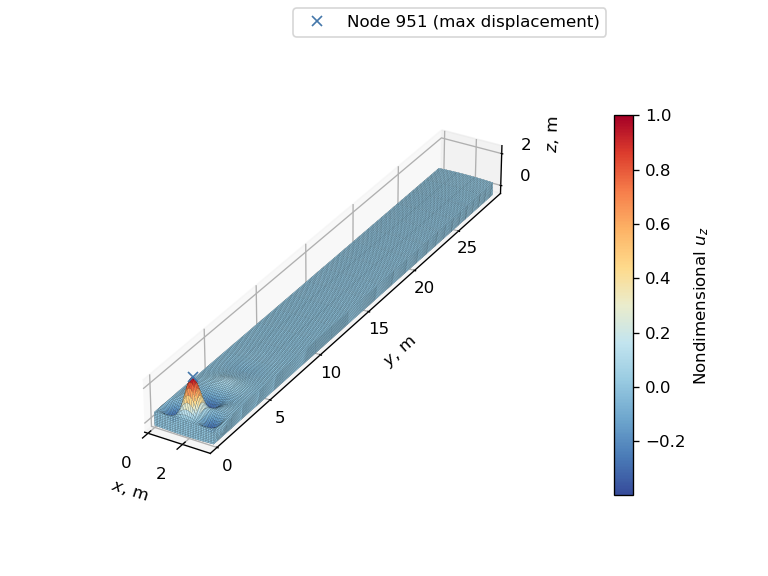

In [33]:
# Create new NastranGroup and set up new OpenMDAO problem
input_name = "sol_105_t15p4"
sol_105_group = optimization_utils.NastranGroup(
    bdf=sol_105_bdf, yield_strength=SIGMA_Y, analysis_directory_path=ANALYSIS_DIRECTORY_PATH, input_name=input_name, run_flag=False)  # create NastranGroup object
sol_105_group.add_subsystem('interp', interp_comp)  # add spline component to the group
sol_105_group.connect('interp.t_val', 'nastran_solver.t_val')  # connect spline component output to the NastranSolver component input
linear_problem = om.Problem(model=sol_105_group, name="sol_105_increased_load")
linear_problem.setup()

# Modify bdf input and run model
sol_105_bdf.load_combinations[LOAD_SET_ID][0].scale_factors[0] = 1.  # apply 1 N so that linear buckling load is equal to buckling load factor
t_0 = H/50  # increased initial thickness
increased_initial_thickness_vector = t_0*np.ones(2)
linear_problem.set_val('interp.t_cp', increased_initial_thickness_vector)  # assign constant thickness vector to spline component input [mm]
linear_problem.run_model()

# Retrieve OP2 object of nonlinear analysis and print buckling load
sol_105_op2 = linear_problem['nastran_solver.op2']
linear_buckling_load = sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].eigrs[0]
print(f"P_SOL 105 = {linear_buckling_load:.0f} N")

# Plot buckling mode
print("Critical buckling mode:")
amplification_factor = 2  # amplification factor for displacements
_, ax, cbar = plot_utils.plot_eigenvector(
    op2=sol_105_op2, subcase_id=SECOND_SUBCASE_ID, displacement_component='tz', colormap='sunset', length_unit='m',
    displacement_amplification_factor=amplification_factor, unit_scale_factor=LENGTH_SCALE_FACTOR)  # plot buckling mode converting from mm to m
plot_utils.plot_max_displacement_node(axes=ax, op2=sol_105_op2, displacement_amplification_factor=amplification_factor, unit_scale_factor=LENGTH_SCALE_FACTOR)
ax.legend()

# Adjust plot and show
adjust_3d_plot(ax, cbar)
plt.show()

The linear buckling load of the initial structure with the new wall thickness is approximately 270 kN, which is about one order of magnitude larger than the design load considered so far. This value is still one order of magnitude smaller than the typical load level of the CRM wingbox, but we consider it to be a good middle ground for our analysis, and we choose it as the new design load for the following optimizations. As far as the critical buckling mode is concerned, we observe that it is totally analogous to that of the previous version of the CRM-like Box Beam.

Before moving to the linear buckling optimization, we assess the nonlinear structural stability response of the CRM-like Box Beam subjected to twice the new design load.

In [34]:
# Create new NastranGroup and set up new OpenMDAO problem
input_name = "sol_106_t15p4"
sol_106_group = optimization_utils.NastranGroup(
    bdf=sol_106_bdf, yield_strength=SIGMA_Y, eigenvalue_scale_factor=EIGENVALUE_SCALE_FACTOR,
    analysis_directory_path=ANALYSIS_DIRECTORY_PATH, input_name=input_name, run_flag=False)  # create NastranGroup object
sol_106_group.add_subsystem('interp', interp_comp)  # add spline component to the group
sol_106_group.connect('interp.t_val', 'nastran_solver.t_val')  # connect spline component output to the NastranSolver component input
nonlinear_problem = om.Problem(model=sol_106_group, name="sol_106_increased_load")
nonlinear_problem.setup()

# Modify bdf input and run model
design_load = np.round(linear_buckling_load)  # set design load equal to linear buckling load
sol_106_bdf.load_combinations[LOAD_SET_ID][0].scale_factors[0] = design_load*2  # scale load to twice the design load
sol_106_bdf.nlpcis[1].mxinc = 450  # increase maximum number of arc-length increments
default_dmap = sol_106_bdf.executive_control_lines[1].replace("stop", "nobuckle")  # get include string for default DMAP
sol_106_bdf.executive_control_lines[1] = default_dmap  # change DMAP line to execute default DMAP
nonlinear_problem.set_val('interp.t_cp', increased_initial_thickness_vector)  # assign constant thickness vector to spline component input [mm]
nonlinear_problem.run_model()  # run analysis

Nastran job sol_106_t15p4.bdf completed
Wall time: 10763.0 s


We plot the eigenvalue and load-displacement diagrams.

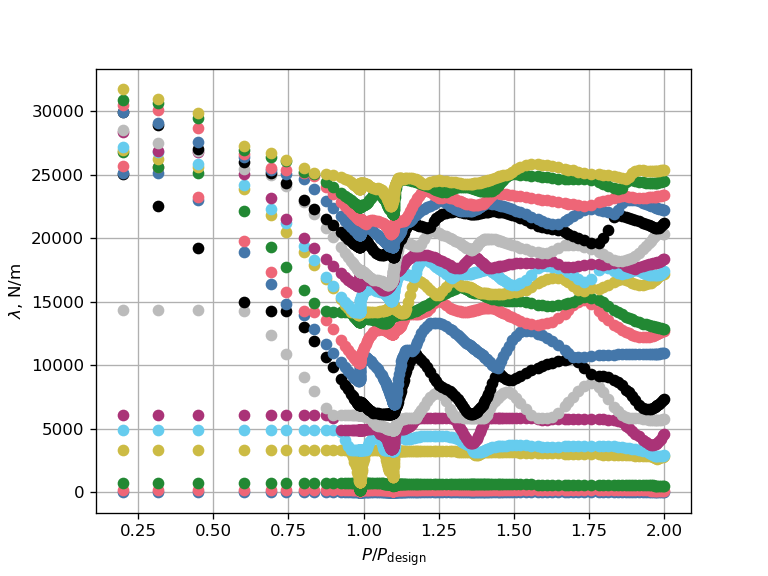

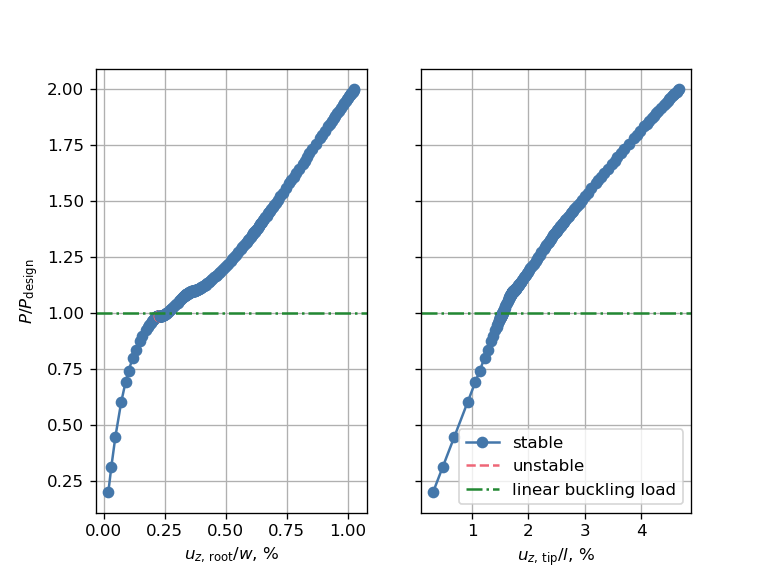

In [35]:
# Read load and displacement history
sol_106_op2 = nonlinear_problem['nastran_solver.op2']
_, loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(
    op2=sol_106_op2, node_ids=monitor_node_ids)
nondimensional_loads = loads[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/design_load  # nondimensionalize loads

# Read eigenvalues of tangent stiffness matrix
f06_path = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.f06')  # path to .f06 file
eigenvalues = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)

# Plot eigenvalues vs applied load
_, ax = plot_utils.plot_eigenvalue_diagram(nondimensional_loads, eigenvalues*EIGENVALUE_SCALE_FACTOR)
ax.set_ylabel("$\lambda$, N/m")
ax.set_xlabel("$P/P_\mathrm{design}$")
ax.grid(visible=True)
plt.show()

# Plot load-displacement diagrams of the initial and linearly optimized structures
fig, axes = plt.subplots(1, 2, sharey=True)  # create a figure with two subplots
for i, node_id in enumerate(displacements):  # loop through the displacements
    plot_utils.plot_2d_load_displacements_stability(
        axes[i],
        displacements[node_id][FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/reference_lengths[i]*100,
        nondimensional_loads,
        eigenvalues,
        MARKERS[0], COLORS[0])  # plot load-displacement curve
    axes[i].axhline(y=1, color=LINEAR_BUCKLING_COLOR, linestyle='-.')  # plot glass ceiling of linear buckling
    axes[i].set_xlabel(f"$u_{{z,\,\mathrm{{{displacement_labels[i]}}}}}/{reference_lengths_labels[i]}$, %")  # set x-axis label
    axes[i].grid(visible=True)

# Create proxy artists for the legend and add legend
axes[1].legend(handles=[stable_line, unstable_line, linear_buckling_line])

# Add y-axis label and show plot
axes[0].set_ylabel("$P/P_\mathrm{design}$")
plt.show()

We observe that the structure has a small loss of stability just before it reaches the design load, meaning that for the present structure subjected to the present applied load the linear buckling analysis is slightly nonconservative. This is an important change with respect to all the analyses performed so far, where we always found that the linear buckling analysis was predicting a larger critical load compared to that found by the nonlinear analysis. We note that this change occurs by simply increasing the applied load level, which induces a larger tip displacement at the design load (1.5% compared to 0.5% of the previous version of the CRM-like Box Beam).

We find the nondimensional load of where the instability occurs and plot the deformation just before and after the instability, amplifying the displacements by a factor 50.

Nondimensional applied load at first instability: 0.99
Deformation before snap-through:


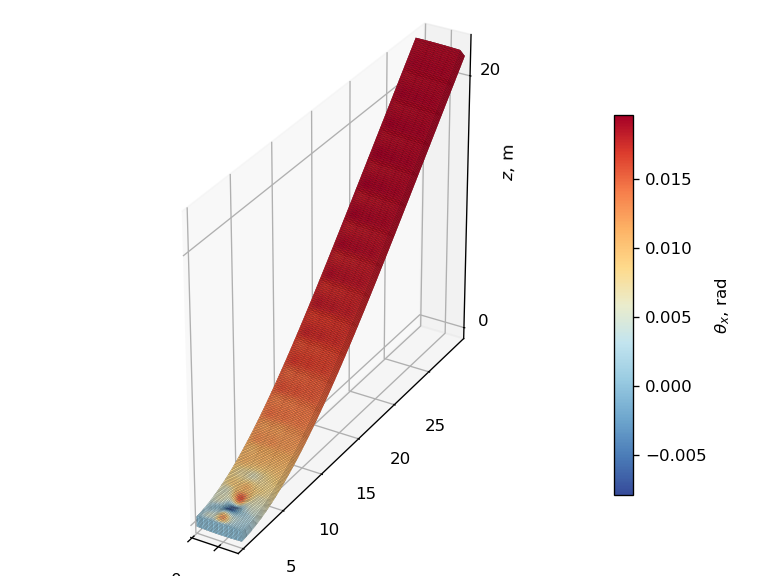

Deformation after snap-through:


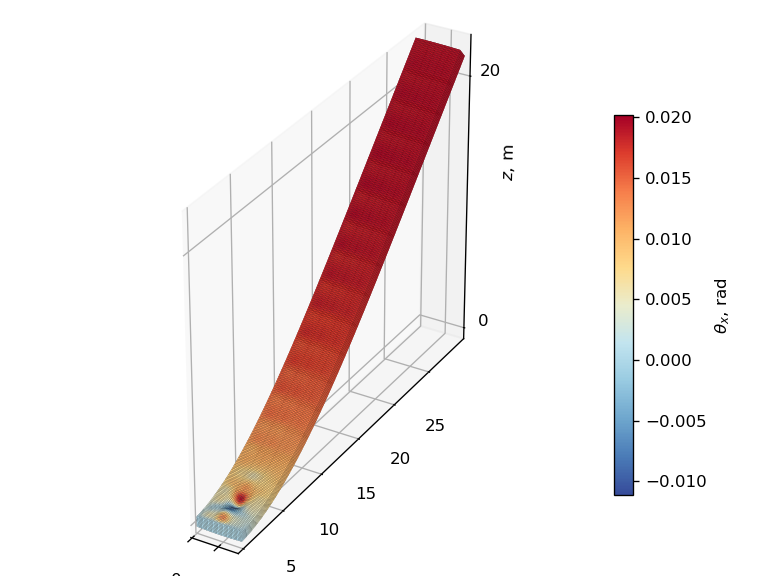

In [36]:
# Find index of first negative eigenvalue and print nondimensional applied load at first instability
first_negative_eigenvalue_index = np.where(eigenvalues[0] < 0)[0][0]
print(f"Nondimensional applied load at first instability: {nondimensional_loads[first_negative_eigenvalue_index]:.2f}")

# Plot deformation before snap-through
print("Deformation before snap-through:")
amplification_factor = 50  # amplification factor for displacements
_, ax, cbar = plot_utils.plot_deformation(
    op2=sol_106_op2, load_step=first_negative_eigenvalue_index, displacement_component='rx', colormap='sunset', length_unit='m',
    unit_scale_factor=LENGTH_SCALE_FACTOR, displacement_amplification_factor=amplification_factor)  # plot deformation converting from mm to m
adjust_3d_plot(ax, cbar)
plt.show()

# Plot deformation after snap-through
offset_index = first_negative_eigenvalue_index + 1
index_after_snap = offset_index + np.argmax(
        nondimensional_loads[offset_index:] >= nondimensional_loads[first_negative_eigenvalue_index - 1])
print("Deformation after snap-through:")
_, ax, cbar = plot_utils.plot_deformation(
    op2=sol_106_op2, load_step=index_after_snap + 1, displacement_component='rx', colormap='sunset', length_unit='m',
    unit_scale_factor=LENGTH_SCALE_FACTOR, displacement_amplification_factor=amplification_factor)  # plot deformation converting from mm to m
adjust_3d_plot(ax, cbar)
plt.show()

The deformation plot before the occurrence of the snap-through shows that the root region of the upper skin experiences a buckling-like response, however delimited to the central rib-stiffener panels. This response is different from that observed in our previous analyses with the lower design load, where the buckling-like response involved also the rear and front rib-stiffener panels. With a closer look into the deformation plot, it is possible to note that the buckling-like shape involves also the two stiffeners. Consequently, the buckling-like response is not a pure rib-stiffener panel buckling, but it tends more towards a global buckling of the overall skin panel between each pair of ribs.

Looking at the deformation plot after the occurrence of the snap-through we can note that there is no change of shape, and we only observe an exacerbation of the rotations.

### Linear Buckling Optimization <a name="load-level-linear"></a>

We set up and run the linear buckling optimization problem.

Initial thickness vector [mm]:
[15.4 15.4]
Initial KS value for buckling load factor: -269507.250
Initial KS value for stress: -420 MPa
Initial mass: 13233 kg


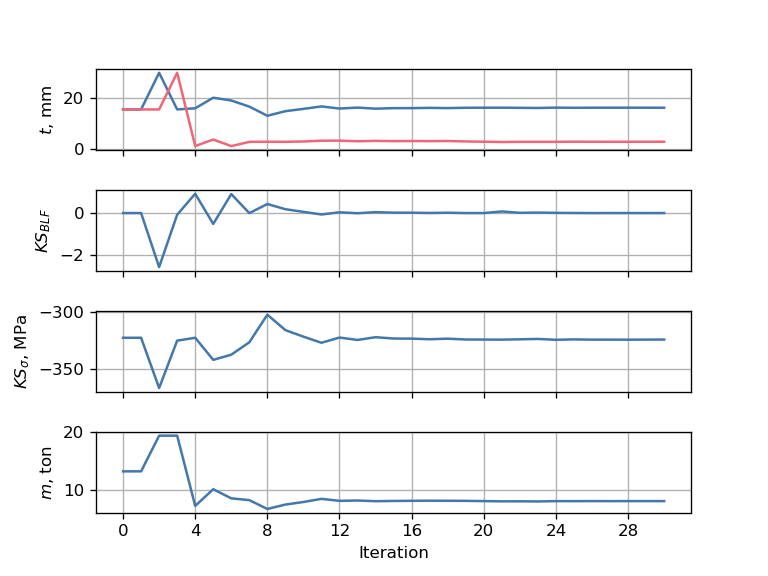

Design variables, constraints and objective at last iteration:
- interp.t_cp: [16.071  2.716]
- nastran_solver.ks_buckling: [0.0007]
- nastran_solver.ks_stress: [-324.202]
- nastran_solver.mass: [8.072]


In [37]:
# Store and print initial mass and KS values
mass_0 = linear_problem['nastran_solver.mass'][0]
ks_buckling_0 = linear_problem['nastran_solver.ks_buckling'][0]
ks_stress_0 = linear_problem['nastran_solver.ks_stress'][0]
print("Initial thickness vector [mm]:")
print(increased_initial_thickness_vector)
print(f"""Initial KS value for buckling load factor: {ks_buckling_0:.3f}
Initial KS value for stress: {ks_stress_0:.0f} MPa
Initial mass: {mass_0*1e3:.0f} kg""")

# Modify bdf input to apply design load
sol_105_bdf.load_combinations[LOAD_SET_ID][0].scale_factors[0] = design_load

# Set default initial thickness vector and name of input file
linear_problem.model.set_input_defaults('interp.t_cp', increased_initial_thickness_vector)
input_name = "sol_105_increased_load_linear_opt"  # default name of input file employed during optimization
linear_problem.model.options['input_name'] = input_name  # change default name of input file

# Choose optimizer
linear_problem.driver = om.ScipyOptimizeDriver()
linear_problem.driver.options['optimizer'] = 'COBYLA'
linear_problem.driver.options['tol'] = OPTIMIZER_TOLERANCE

# Add design variable, objective and constraints
linear_problem.model.add_design_var(
    'interp.t_cp', lower=thickness_bounds[0], upper=thickness_bounds[1], ref0=thickness_bounds[0], ref=t_0)  # scale thickness so that the lower bound is 0 and initial value is 1
linear_problem.model.add_objective('nastran_solver.mass', ref0=mass_0/2, ref=mass_0)  # scale mass so that half of the initial mass is 0 and the initial mass is 1
linear_problem.model.add_constraint('nastran_solver.ks_buckling', upper=0.)  # KS function for buckling load factor is not scaled because buckling load factor is already a ratio
linear_problem.model.add_constraint('nastran_solver.ks_stress', upper=0., ref=np.abs(ks_stress_0))  # scale KS function for stresses so that the initial value is 1

# Add recorder to the driver
recorder_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.sql')
recorder = om.SqliteRecorder(recorder_filepath)  # create recorder
linear_problem.driver.add_recorder(recorder)  # attach recorder to the driver

# Run optimization
linear_problem.setup()  # re-setup problem before running optimization
linear_problem.set_solver_print(0)  # disable solver output
linear_problem.driver.options['debug_print'] = ['desvars','nl_cons','objs']  # print design variables, constraints and objectives
if False:  # set True or False to run optimization or not
    linear_problem.run_driver()  # run optimization
linear_problem.cleanup()  # clean up problem

# Plot optimization history and print results
_, linear_opt_histories = optimization_utils.plot_optimization_history(recorder_filepath)  # plot optimization history

We calculate the mass reduction with respect to the initial structure with constant thickness.

In [38]:
mass_percentage_variation = (linear_opt_histories['nastran_solver.mass'][-1, 0]/mass_0 - 1)*100
print(f"Mass variation w.r.t. initial structure: {mass_percentage_variation:.1f} %")

Mass variation w.r.t. initial structure: -39.0 %


We plot the critical buckling mode of the linearly optimized structure.

c:\Users\qa21944\Github\phd-jupyter-notebooks\notebooks\resources\plot_utils.py:342: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


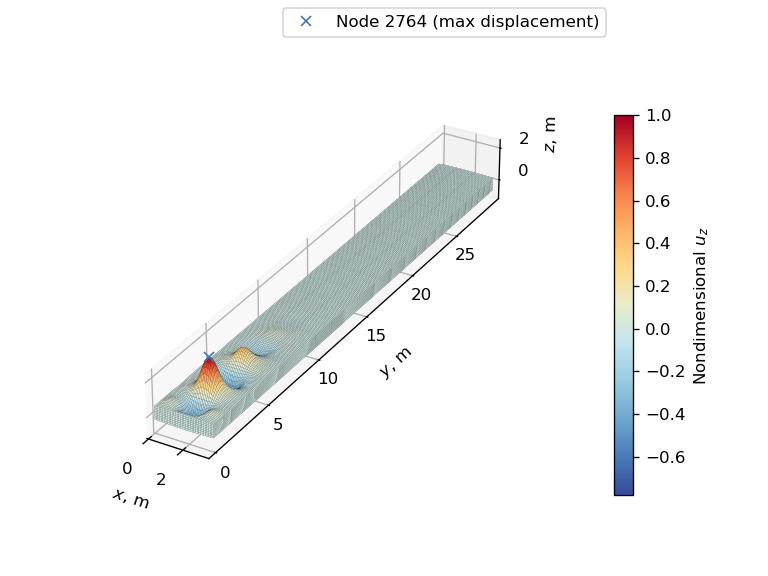

In [39]:
# Read op2 file of analysis of optimized structure
sol_105_op2 = read_op2(os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.op2'), load_geometry=True, debug=None)

# Plot critical buckling mode and highlight max displacement node
amplification_factor = 2
_, ax, cbar = plot_utils.plot_eigenvector(
    op2=sol_105_op2, subcase_id=SECOND_SUBCASE_ID, displacement_component='tz', colormap='sunset',
    displacement_amplification_factor=amplification_factor, unit_scale_factor=LENGTH_SCALE_FACTOR)  # convert from mm to m
max_displacement_node_id = plot_utils.plot_max_displacement_node(
    axes=ax, op2=sol_105_op2, unit_scale_factor=LENGTH_SCALE_FACTOR, displacement_amplification_factor=amplification_factor)
ax.legend()
adjust_3d_plot(ax, cbar)
plt.show()

We observe that the critical buckling mode is now a global buckling of the second rib-spar panel, which involves also the stiffeners.

#### Nonlinear response of linearly optimized structure

We perform a nonlinear analysis of the linearly optimized structure subjected to twice the design load and we plot the eigenvalue diagram.

Nastran job sol_106_increased_load_linear_opt.bdf completed
Wall time: 38834.0 s


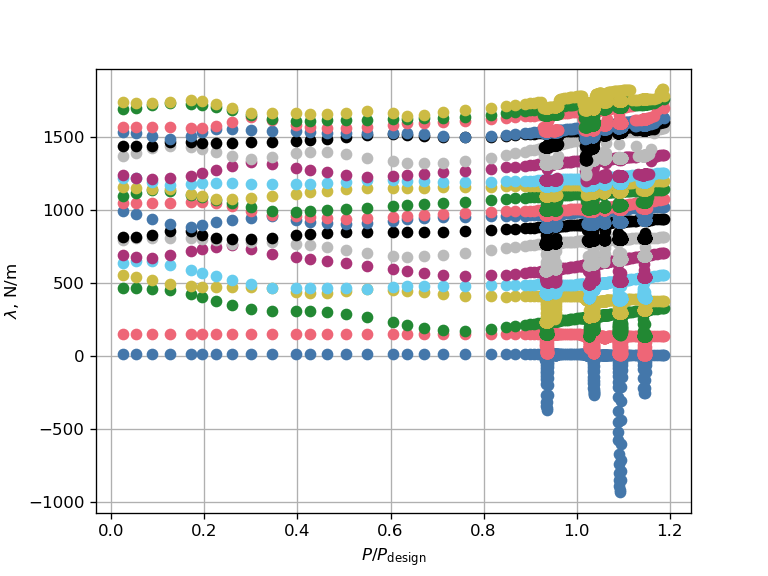

In [40]:
# Change input name and re-set up problem
input_name = "sol_106_increased_load_linear_opt"
nonlinear_problem.model.options['input_name'] = input_name
nonlinear_problem.setup()

# Assign thickness vector of linearly optimized structure to spline component input
linear_opt_thickness_vector = linear_opt_histories['interp.t_cp'][-1, :]
nonlinear_problem.set_val('interp.t_cp', linear_opt_thickness_vector)

# Run analysis
nonlinear_problem.run_model()

# Read load history from op2 file
sol_106_op2 = nonlinear_problem['nastran_solver.op2']  # retrieve op2 object
_, loads, _ = pynastran_utils.read_load_displacement_history_from_op2(op2=sol_106_op2)
nondimensional_loads = loads[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/design_load  # nondimensionalize loads

# Read eigenvalues of tangent stiffness matrix
f06_path = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.f06')  # path to .f06 file
eigenvalues = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)

# Plot eigenvalues vs applied load
_, ax = plot_utils.plot_eigenvalue_diagram(nondimensional_loads, eigenvalues*EIGENVALUE_SCALE_FACTOR)
ax.set_ylabel("$\lambda$, N/m")
ax.set_xlabel("$P/P_\mathrm{design}$")
plt.show()

The analysis does not converge to the prescribed load because it reaches the maximum number of allowed increments. Within the investigated range of applied loads, we observe four different regions of instability, the first occurring at approximately $P/P_\mathrm{design}=0.94$. Therefore, also for the linearly optimized structure we note that the linear buckling analysis is nonconservative, as it predicts a larger critical load with respect to the nonlinear analysis.

We plot the load-disagrams considering the displacement along the $z$-axis of the nodes at the center of the first and second rib-spar panels, and the tip displacement.

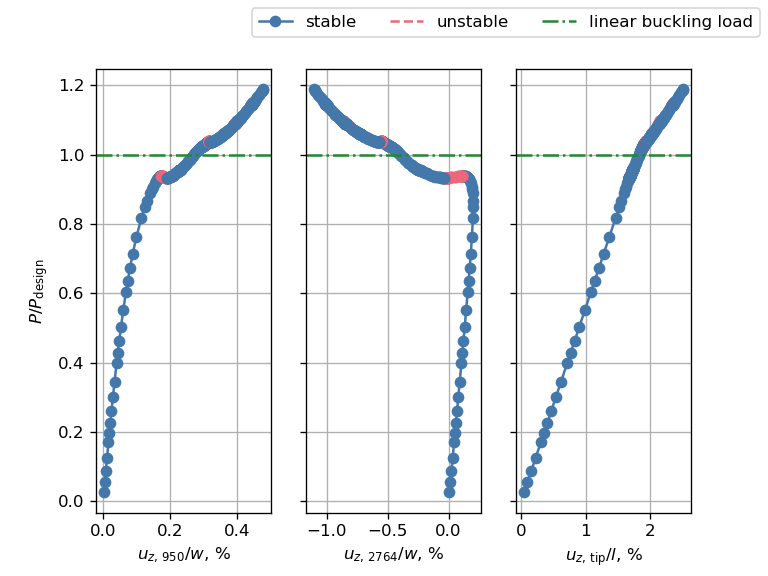

In [41]:
# # Update monitor node ids, reference lengths and displacement labels
monitor_node_ids.insert(1, max_displacement_node_id)  # add node id of max displacement node of linearly optimized structure
reference_lengths.insert(1, W)  # add reference length
reference_lengths_labels.insert(1, "w")  # add reference length label
displacement_labels[0] = monitor_node_ids[0]  # change label of root node to node id
displacement_labels.insert(1, max_displacement_node_id)  # add label for max displacement node of linearly optimized structure

# Read displacement history from op2 file
sol_106_op2 = nonlinear_problem['nastran_solver.op2']  # retrieve op2 object
_, _, displacements = pynastran_utils.read_load_displacement_history_from_op2(op2=sol_106_op2, node_ids=monitor_node_ids)

# Plot load-displacement diagrams of the initial and linearly optimized structures
fig, axes = plt.subplots(1, 3, sharey=True)  # create a figure with two subplots
for i, node_id in enumerate(displacements):  # loop through the displacements
    plot_utils.plot_2d_load_displacements_stability(
        axes[i],
        displacements[node_id][FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/reference_lengths[i]*100,
        nondimensional_loads,
        eigenvalues,
        MARKERS[0], COLORS[0])  # plot load-displacement curve
    axes[i].axhline(y=1, color=LINEAR_BUCKLING_COLOR, linestyle='-.')  # plot glass ceiling of linear buckling
    axes[i].set_xlabel(f"$u_{{z,\,\mathrm{{{displacement_labels[i]}}}}}/{reference_lengths_labels[i]}$, %")  # set x-axis label
    axes[i].grid(visible=True)

# Create proxy artists for the legend and add legend
fig.legend(handles=[stable_line, unstable_line, linear_buckling_line], ncol=3)

# Add y-axis label and show plot
axes[0].set_ylabel("$P/P_\mathrm{design}$")
plt.show()

The first unstable region is clearly visible in the plots of the two local displacements over the root of the top skin, while the other unstable regions are more hidden.

We now plot the deformation just before and just after the first snap-through, employing an amplification factor of 50 for the displacements.

Nondimensional applied load at first instability: 0.94
Deformation before snap-through:


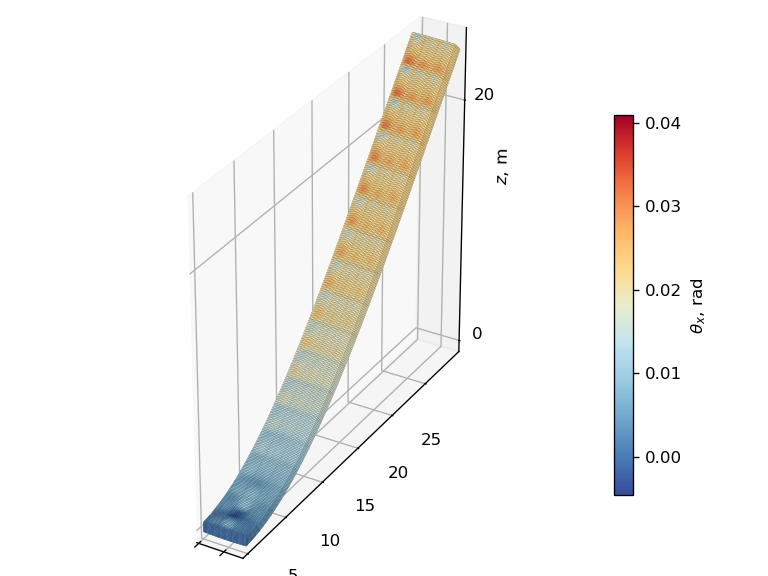

Deformation after snap-through:


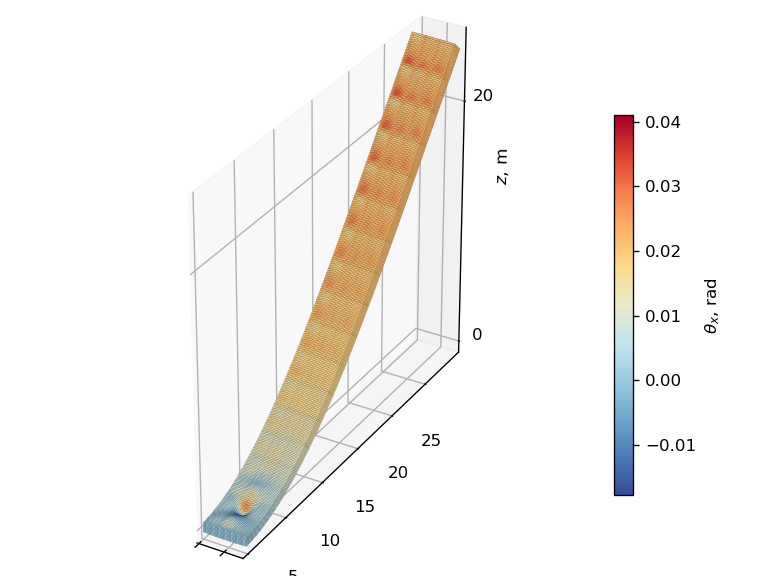

In [42]:
# Find index of first negative eigenvalue and print nondimensional applied load at first instability
first_negative_eigenvalue_index = np.where(eigenvalues[0] < 0)[0][0]
print(f"Nondimensional applied load at first instability: {nondimensional_loads[first_negative_eigenvalue_index]:.2f}")

# Plot deformation before snap-through
print("Deformation before snap-through:")
amplification_factor = 50  # amplification factor for displacements
_, ax, cbar = plot_utils.plot_deformation(
    op2=sol_106_op2, load_step=first_negative_eigenvalue_index, displacement_component='rx', colormap='sunset', length_unit='m',
    unit_scale_factor=LENGTH_SCALE_FACTOR, displacement_amplification_factor=amplification_factor)  # plot deformation converting from mm to m
adjust_3d_plot(ax, cbar)
plt.show()

# Plot deformation after snap-through
offset_index = first_negative_eigenvalue_index + 1
index_after_snap = offset_index + np.argmax(
        nondimensional_loads[offset_index:] >= nondimensional_loads[first_negative_eigenvalue_index - 1])
print("Deformation after snap-through:")
_, ax, cbar = plot_utils.plot_deformation(
    op2=sol_106_op2, load_step=index_after_snap + 1, displacement_component='rx', colormap='sunset', length_unit='m',
    unit_scale_factor=LENGTH_SCALE_FACTOR, displacement_amplification_factor=amplification_factor)  # plot deformation converting from mm to m
adjust_3d_plot(ax, cbar)
plt.show()

We note that before the occurence of the first snap-through, the deformation over the first few top skin panels presents an incipit of global panel buckling, with the first panel bending slighlty up and the second panel bending slightly down. After the snap-through, the deformation is amplified, but the shape remains the same.

### Nonlinear Structural Stability Optimization <a name="load-level-nonlinear"></a>

We apply the design load to the linearly optimized structure and run a nonlinear analysis to record the initial values of the constraint and objective functions for the nonlinear structural stability optimization.

In [43]:
# Scale load to design load, change DMAP and run model
sol_106_bdf.load_combinations[LOAD_SET_ID][0].scale_factors[0] = design_load  # scale load to design load
sol_106_bdf.executive_control_lines[1] = dmap_stop  # change DMAP command to store eigenvectors
input_name = "sol_106_increased_load_nonlinear_opt_start"
nonlinear_problem.model.nastran_solver.options['input_name'] = input_name
sol_106_bdf.nlpcis[1].mxinc = 200  # decrease maximum number of increments to speed up optimization
nonlinear_problem.run_model()

# Store and print initial KS values and mass
ks_stability_0 = nonlinear_problem["nastran_solver.ks_stability"][0]
ks_stress_0 = nonlinear_problem["nastran_solver.ks_stress"][0]
mass_0 = nonlinear_problem['nastran_solver.mass'][0]
print(f"""Initial KS value for stability: {ks_stability_0:.3f} N/m
Initial KS value for stress: {ks_stress_0:.0f} MPa
Initial mass: {mass_0*1e3:.0f} kg""")

Nastran job sol_106_increased_load_nonlinear_opt_start.bdf completed
Wall time: 1937.0 s
Initial KS value for stability: 2.902 N/m
Initial KS value for stress: -330 MPa
Initial mass: 8072 kg


As observed earlier, the initial design for the nonlinear structural stability optimization is unfeasible, given that the structure loses stability before reaching the design load. For this reason we now scale the stability constraint function with the smallest eigenvalue of the first converged increment rather than with the KS value resulting from the overall analysis.

In [44]:
# Set default input values of sol_106 component
nonlinear_problem.model.set_input_defaults('interp.t_cp', linear_opt_thickness_vector)
input_name = "sol_106_increased_load_nonlinear_opt"
nonlinear_problem.model.options['input_name'] = input_name

# Choose optimizer
nonlinear_problem.driver = om.ScipyOptimizeDriver()
nonlinear_problem.driver.options['optimizer'] = 'COBYLA'
nonlinear_problem.driver.options['tol'] = OPTIMIZER_TOLERANCE

# Add design variable, objective and constraints
nonlinear_problem.model.add_design_var(
    'interp.t_cp', lower=thickness_bounds[0], upper=thickness_bounds[1], ref0=thickness_bounds[0], ref=linear_opt_thickness_vector[0])  # scale thickness so that the lower bound is 0 and initial value at root is 1
nonlinear_problem.model.add_objective('nastran_solver.mass', ref0=mass_0/2, ref=mass_0)  # scale mass so that half of the initial mass is 0 and the initial mass is 1
nonlinear_problem.model.add_constraint('nastran_solver.ks_stability', upper=0., ref=eigenvalues[0][0]*EIGENVALUE_SCALE_FACTOR)  # scale KS function for nonlinear structural stability so that the initial value is 1
nonlinear_problem.model.add_constraint('nastran_solver.ks_stress', upper=0., ref=np.abs(ks_stress_0))  # scale KS function for stresses so that the initial value is 1
nonlinear_problem.model.add_constraint('nastran_solver.load_factor', lower=.99)  # final applied load should be at least 99% of the design load

We finally add the OpenMDAO recorder and run the optimization.

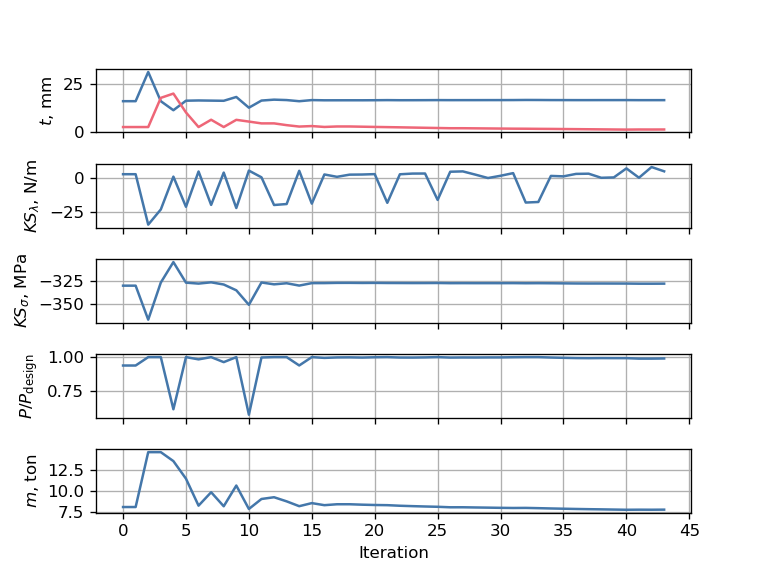

Design variables, constraints and objective at last iteration:
- interp.t_cp: [16.6123  1.4556]
- nastran_solver.ks_stability: [5.0411]
- nastran_solver.ks_stress: [-327.803]
- nastran_solver.load_factor: [0.99]
- nastran_solver.mass: [7.763]


In [45]:
# Add recorder
recorder_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.sql')
recorder = om.SqliteRecorder(recorder_filepath)  # create recorder
nonlinear_problem.driver.add_recorder(recorder)  # attach recorder to the driver

# Run optimization
nonlinear_problem.setup()  # re-setup problem
nonlinear_problem.set_solver_print(0)  # disable solver output
nonlinear_problem.driver.options['debug_print'] = ['desvars','nl_cons','objs']  # print design variables, constraints and objectives
if False:  # set True or False to run optimization or not
    nonlinear_problem.run_driver()  # run optimization
nonlinear_problem.cleanup()  # clean up problem

# Plot optimization history and print results
_, nonlinear_opt_histories = optimization_utils.plot_optimization_history(recorder_filepath)  # plot optimization history

The optimization employs about 26.7 hours to complete and ends on an unfeasible design point (positive stability constraint function value). Let's find the last feasible design and print the final values of design variables, constraints and objective.

In [46]:
# Find index of last feasible design
feasible_design_index = np.where(nonlinear_opt_histories['nastran_solver.ks_stability'][:, 0] < OPTIMIZER_TOLERANCE)[0][-1]

# Print design variables, constraints and objective at last feasible iteration
print("Design variables, constraints and objective at last feasible iteration:")
for key in nonlinear_opt_histories:
    print(f"- {key}: {nonlinear_opt_histories[key][feasible_design_index]}")

# Find and print mass percentage variation w.r.t. initial structure
mass_percentage_variation = (nonlinear_opt_histories['nastran_solver.mass'][feasible_design_index, 0]/mass_0 - 1)*100
print(f"Mass variation w.r.t. linearly optimized structure: {mass_percentage_variation:.1f} %")

Design variables, constraints and objective at last feasible iteration:
- interp.t_cp: [16.6859  1.7893]
- nastran_solver.ks_stability: [-17.6909]
- nastran_solver.ks_stress: [-327.2767]
- nastran_solver.load_factor: [1.]
- nastran_solver.mass: [7.938]
Mass variation w.r.t. linearly optimized structure: -1.7 %


Despite starting from an unfeasible design point, we note that the nonlinear structural stability optimization has managed to reduce the mass by sligthly increasing the root thickness and by decreasing the tip thickness. We run the nonlinear analysis for the last feasible design and plot eigenvalues of the tangent stiffness matrix.

Nastran job sol_106_increased_load_nonlinear_opt_feasible.bdf completed
Wall time: 1925.0 s


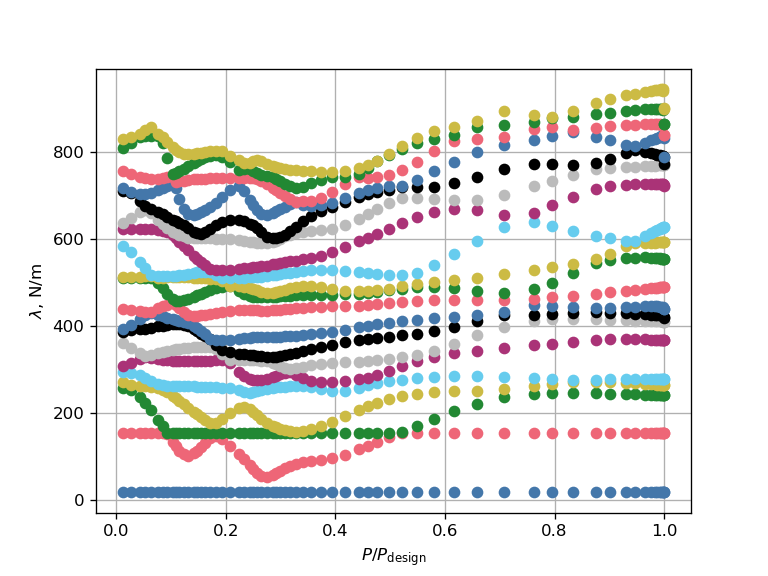

In [47]:
# Run analysis of last feasible design
nonlinear_opt_thickness_vector = nonlinear_opt_histories['interp.t_cp'][feasible_design_index]
nonlinear_problem.set_val('interp.t_cp', nonlinear_opt_thickness_vector)
input_name = "sol_106_increased_load_nonlinear_opt_feasible"
nonlinear_problem.model.nastran_solver.options['input_name'] = input_name
nonlinear_problem.run_model()

# Read load and displacement history
sol_106_op2 = nonlinear_problem['nastran_solver.op2']
_, loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(
    op2=sol_106_op2, node_ids=monitor_node_ids)
nondimensional_loads = loads[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/design_load  # nondimensionalize loads

# Read eigenvalues of tangent stiffness matrix
f06_path = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.f06')  # path to .f06 file
eigenvalues = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)

# Plot eigenvalues vs applied load
_, ax = plot_utils.plot_eigenvalue_diagram(nondimensional_loads, eigenvalues*EIGENVALUE_SCALE_FACTOR)
ax.set_ylabel("$\lambda$, N/m")
ax.set_xlabel("$P/P_\mathrm{design}$")
ax.grid(visible=True)
plt.show()

Before plotting the load-displacement diagrams of the nonlinearly optimized structure, we calculate its linear buckling load.

Nastran job sol_105_increased_load_nonlinear_opt.bdf completed
Wall time: 27.0 s
P_SOL 105/P_design = 0.35
Critical buckling mode:


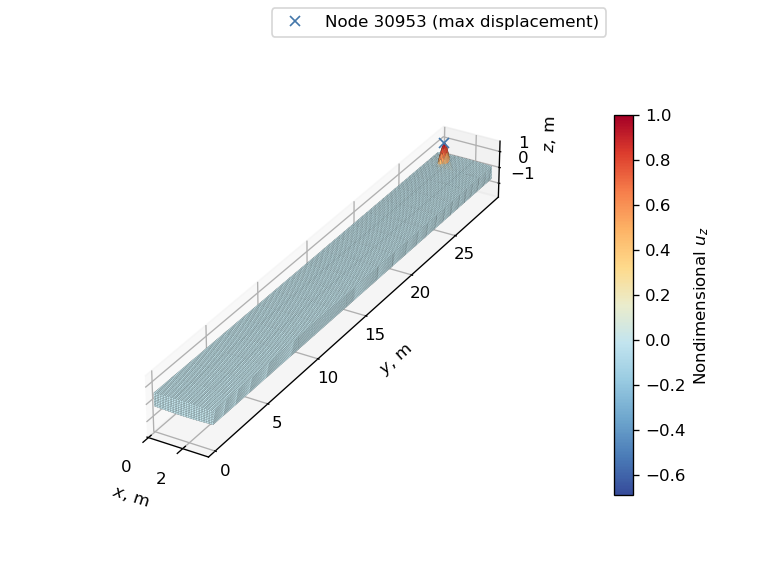

In [48]:
# Modify name of bdf file and input thicknesses and run analysis
linear_problem.model.options['input_name'] = "sol_105_increased_load_nonlinear_opt"
linear_problem.setup()
linear_problem.set_val('interp.t_cp', nonlinear_opt_thickness_vector)
linear_problem.run_model()

# Retrieve OP2 object of nonlinear analysis and print buckling load
sol_105_op2 = linear_problem['nastran_solver.op2']
nonlinear_opt_blf = sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].eigrs[0]
print(f"P_SOL 105/P_design = {nonlinear_opt_blf:.2f}")

# Plot buckling mode
print("Critical buckling mode:")
amplification_factor = 2  # amplification factor for displacements
_, ax, cbar = plot_utils.plot_eigenvector(
    op2=sol_105_op2, subcase_id=SECOND_SUBCASE_ID, displacement_component='tz', colormap='sunset', length_unit='m',
    displacement_amplification_factor=amplification_factor, unit_scale_factor=LENGTH_SCALE_FACTOR)  # plot buckling mode converting from mm to m
plot_utils.plot_max_displacement_node(
    axes=ax, op2=sol_105_op2, displacement_amplification_factor=amplification_factor, unit_scale_factor=LENGTH_SCALE_FACTOR)
ax.legend()

# Adjust plot and show
adjust_3d_plot(ax, cbar)
plt.show()

The critical buckling mode of the nonlinearly optimized structure subjected to an increased load level is totally analogous to that of the nonlinearly optimized structure previously analyzed. It can be inferred that, despite the linearly optimized structure showed the critical buckling mode to be associated to the global buckling of the second top skin panel, the cylindrical shell roof buckling mode of the tip of the bottom skin was close to be critical. In fact by increasing the root thickness and reducing the tip thickness, the nonlinear structural stability optimization has made the latter buckling mode critical for the nonlinearly optimized structure according to the linear analysis, with the buckling load amounting to only 35% of the design load.

We now plot the load-displacement diagrams of the nonlinearly optimized structure, visualizing the line of the linear buckling load.

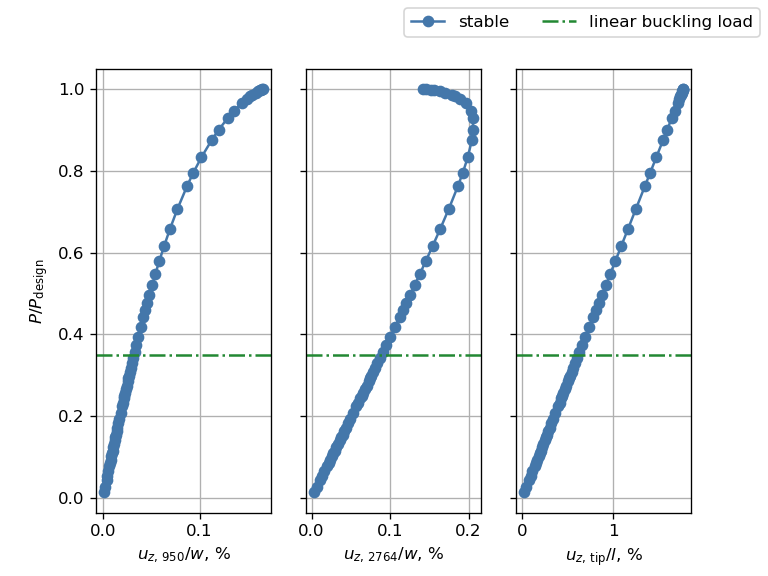

In [49]:
# Plot load-displacement diagrams of the initial and linearly optimized structures
fig, axes = plt.subplots(1, 3, sharey=True)  # create a figure with two subplots
for i, node_id in enumerate(displacements):  # loop through the displacements
    plot_utils.plot_2d_load_displacements_stability(
        axes[i],
        displacements[node_id][FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/reference_lengths[i]*100,
        nondimensional_loads,
        eigenvalues,
        MARKERS[0], COLORS[0])  # plot load-displacement curve
    axes[i].axhline(y=nonlinear_opt_blf, color=LINEAR_BUCKLING_COLOR, linestyle='-.')  # plot glass ceiling of linear buckling
    axes[i].set_xlabel(f"$u_{{z,\,\mathrm{{{displacement_labels[i]}}}}}/{reference_lengths_labels[i]}$, %")  # set x-axis label
    axes[i].grid(visible=True)

# Create proxy artists for the legend and add legend
fig.legend(handles=[stable_line, linear_buckling_line], ncol=2)

# Add y-axis label and show plot
axes[0].set_ylabel("$P/P_\mathrm{design}$")
plt.show()

As we can see the nonlinear structural stability optimization has moved the first instability to a higher load level with respect to the linearly optimized structure and has placed it just above the design load.

Finally we plot the deformation at the design load.

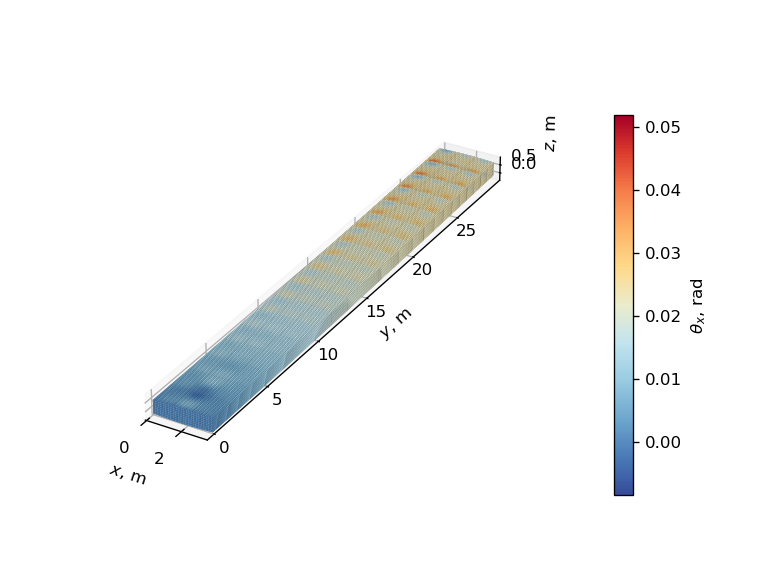

In [50]:
_, ax, cbar = plot_utils.plot_deformation(
    op2=sol_106_op2, displacement_component='rx', colormap='sunset', unit_scale_factor=LENGTH_SCALE_FACTOR)  # plot deformation converting from mm to m
adjust_3d_plot(ax, cbar)
plt.show()

Similarly to what observed for the linearly optimized structure, also in this case the deformation shows an incipt of a global buckling of the skin panels close to the root. In addition, we note areas of larger and smaller rotation towards the tip, just next to the ribs, where the skin is not supported and is pulled up by the applied load.

## Conclusion <a name="conclusion"></a>

***

In this notebook we have performed a structural optimization of the CRM-like Box Beam under a combined bending and torsional load. We have increased the design load to a level that is a middle ground between the one considered so far for our optimizations and the typical load level of the CRM wingbox. We have observed that the linear buckling analysis is nonconservative for the initial and linearly optimized structures, as it predicts a larger critical load compared to that found by the nonlinear analysis. Consequently, the nonlinear structural stability optimization had to start from an unfeasible design point, but, despite this, it still managed to reduce the mass by slightly increasing the root thickness and by decreasing the tip thickness. The nonlinear structural stability optimization moved the first instability to a higher load level with respect to the linearly optimized structure and placed it just above the design load. The deformation at the design load shows an incipt of a global buckling of the skin panels close to the root, with areas of larger and smaller rotation towards the tip, just next to the ribs, where the skin is not supported and is pulled up by the applied load.